# Optimizing diversified investment portfolios considering cryptocurrencies and other Brazilian financial products, using Markowitz model approach, GARCH models and Genetic algorithms.

*** By Pablo Calvache***

In [4]:
#Imports

from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import certifi
import urllib3
import pycurl
import datetime, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

# Data extraction

Using Python curl and HTML libraries, data from websites containing closing prices of either stocks and cryptocurrencies assets, is extracted and summarized. Such data is public!

** OBS: ** Regardless the Brazilian stocks prices are given in *BRL (Real)* and the crypto prices are given in *USD (American Dolar)*,  transforming from USD to BRL is desnecessary due only differentiated series are considered by Markowitz models. 

## Stock info

Data at this stage, is obtained from Yahoo finance portal because of its HTML structure and easiness at reading.  

In [6]:
# https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1452045600&period2=1515549600&interval=1d&filter=history&frequency=1d
def date_to_seconds(date_string, formatting = '%d-%m-%Y' ):
    t = datetime.strptime(date_string, formatting)
    return int(time.mktime(t.timetuple()))

def get_historical_data(name, init, end):
    data_close_prices, index_date = [], []
    url = "https://br.finance.yahoo.com/quote/"+name+"/history?period1="+str(init)+"&period2="+str(end)+"&interval=1d&filter=history&frequency=1d"
    print('Downloading from ... '+ url)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    rows = BeautifulSoup(r.data, 'html.parser').findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        #data.append({'date': divs[0].text, 
                    #'open': divs[1].text,
                    #'max': divs[2].text,
                    #'min': divs[3].text,
                    #'close': divs[4].text})
                    
        if len(divs) < 4:
            continue
            
        data_close_prices.append(float(divs[4].text.replace(",", ".")))
        index_date.append(divs[0].text)
    
    key = 'stock_close_'+name.split('.')[0]
    return pd.DataFrame({key:list(reversed(data_close_prices))}, index = list(reversed(index_date)))

def download_portafolio_as_pandas(papers, interval):
    portafolio_pd = pd.DataFrame()
    for paper in papers:
        init_sec = date_to_seconds(interval['init'])
        end_sec = date_to_seconds(interval['end'])
        if portafolio_pd.size == 0:
            portafolio_pd = get_historical_data(paper, init_sec, end_sec)
        else:
            portafolio_pd = portafolio_pd.join(get_historical_data(paper, init_sec, end_sec), how ='left')
    
    return portafolio_pd

In [37]:
# downloading data

papers = ["ABEV3.SA", "ITUB4.SA", "BBDC3.SA", "PETR4.SA", "VALE3.SA", "BSAN33.SA", "ITSA4.SA", 
          "VIVT4.SA", "BBSE3.SA", "CIEL3.SA"]

#"BRSR6.SA","ELET6.SA","CESP6.SA","PCAR4.SA",
#          "CGAS5.SA","CMIG4.SA","CPLE6.SA","ELPL4.SA",

# Yahoo allows to download 100 days only, therefore
time_intervals = [{'init' : '01-06-2018', 'end' : '31-07-2018'},
                  {'init' : '01-03-2018', 'end' : '31-05-2018'},
                  {'init' : '01-12-2017', 'end' : '28-05-2018'},
                  {'init' : '01-09-2017', 'end' : '30-11-2017'},
                  {'init' : '01-06-2017', 'end' : '31-08-2017'},
                  {'init' : '01-04-2017', 'end' : '30-06-2017'},
                  {'init' : '01-01-2017', 'end' : '31-03-2017'}]


stock_prices_pd = pd.DataFrame()
for time_interval in time_intervals:
    if stock_prices_pd.size == 0:
        stock_prices_pd = download_portafolio_as_pandas(papers, time_interval)
    else:
        stock_prices_pd = pd.concat([download_portafolio_as_pandas(papers, time_interval), stock_prices_pd])

#### Formatting Date index

In [38]:
def formating_yahoo_date(date_text):
    date_text = date_text.replace(' de ', '-')
    splitted_date = date_text.split('-')
    day, month_pt, year = splitted_date[0], splitted_date[1], splitted_date[2]
    return {
      'dez': lambda year, day: year + '-' + '12' + '-' + day,
      'nov': lambda year, day: year + '-' + '11' + '-' + day,
      'out': lambda year, day: year + '-' + '10' + '-' + day,
      'set': lambda year, day: year + '-' + '09' + '-' + day,
      'ago': lambda year, day: year + '-' + '08' + '-' + day,
      'jul': lambda year, day: year + '-' + '07' + '-' + day,
      'jun': lambda year, day: year + '-' + '06' + '-' + day,
      'mai': lambda year, day: year + '-' + '05' + '-' + day,
      'abr': lambda year, day: year + '-' + '04' + '-' + day,
      'mar': lambda year, day: year + '-' + '03' + '-' + day,
      'fev': lambda year, day: year + '-' + '02' + '-' + day,
      'jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

stock_prices_pd.index = [formating_yahoo_date(date_yahoo) for date_yahoo in stock_prices_pd.index.values]

In [41]:
stock_prices_pd.head()

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
2017-01-02,16.31,33.53,23.82,14.66,25.06,16.0,7.41,44.08,27.82,22.71
2017-01-03,16.64,34.95,24.77,15.50,26.17,16.0,7.74,44.53,28.81,23.34
2017-01-04,16.51,35.10,24.76,15.50,25.70,16.0,7.78,44.35,29.72,23.01
2017-01-05,16.60,35.58,24.90,15.75,26.68,16.0,7.86,43.60,29.12,22.76
2017-01-06,16.46,35.70,25.09,15.66,25.97,16.0,7.83,43.71,28.67,22.81


## Croptocurrencies

#### Loading Objects from coinMarket

Due criptocurrencies are harder to trade and exchange, an important criterion in ordet to select the correct ones is the ease in exhancging... 

In [42]:
#date format = 20170817
def formating_coinmarket_date(date_text):
    date_text = date_text.replace(',', '')
    splitted_date = date_text.split(' ')
    day, month_pt, year = splitted_date[1], splitted_date[0], splitted_date[2]
    return {
      'Dec': lambda year, day: year + '-' + '12' + '-' + day,
      'Nov': lambda year, day: year + '-' + '11' + '-' + day,
      'Oct': lambda year, day: year + '-' + '10' + '-' + day,
      'Sep': lambda year, day: year + '-' + '09' + '-' + day,
      'Aug': lambda year, day: year + '-' + '08' + '-' + day,
      'Jul': lambda year, day: year + '-' + '07' + '-' + day,
      'Jun': lambda year, day: year + '-' + '06' + '-' + day,
      'May': lambda year, day: year + '-' + '05' + '-' + day,
      'Apr': lambda year, day: year + '-' + '04' + '-' + day,
      'Mar': lambda year, day: year + '-' + '03' + '-' + day,
      'Feb': lambda year, day: year + '-' + '02' + '-' + day,
      'Jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

def get_values_table(source_path, currency, start_date, end_date):
    url = source_path.format(currency = currency, start_date = start_date, end_date = end_date)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    print('Downloading from ... '+ url)
    r = http.request('GET', url)
    #r = urllib.urlopen(url).read() # Python 2
    soup = BeautifulSoup(r.data, 'html.parser')
    table = soup.find('table')
    data = []
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    df_temp = pd.DataFrame.from_records(list(reversed(data)))
    df_temp.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
   
    close_prices = [float(close) for close in list(df_temp['Close'])]
    df_close = pd.DataFrame({'ccurr_'+currency+'_close' : close_prices}, index = df_temp['Date'])
    
    return df_close

def download_cripto_currencies_close_price_as_pandas(currencies, date_interval):
    source_path = 'https://coinmarketcap.com/currencies/{currency}/historical-data/?start={start_date}&end={end_date}'
    ccurrencies_pd = pd.DataFrame()
    for key, val in currencies.items():
        if ccurrencies_pd.size == 0:
            ccurrencies_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
        else:
            temp_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
            ccurrencies_pd = ccurrencies_pd.join(temp_pd, how ='left')
    
    return ccurrencies_pd

def from_usd_to_pt(currencies_pd, exchange_pd):
    currencies_pd_temp = currencies_pd.join(exchange_pd, how='inner')
    return cripto_currencies_pd.transform(lambda x: x * currencies_pd_temp['close_price_usd_pt'])

In [43]:
currencies = {'bitcoin' : 'bitcoin', 
              'ethereum' : 'ethereum', 
              'bitcoin_cash' : 'bitcoin-cash', 
              'litecoin' : 'litecoin',
              'ripple' : 'ripple',
              'Cardano' : 'cardano',
              'NEO' : 'neo',
              'stellar': 'stellar',
              'monero' : 'monero',
              'EOS' : 'eos',
              'IOTA' : 'iota',
              'EOS' : 'eos',
              'tether' : 'tether',
              'TRON' : 'tron',
              'dash' : 'dash'}

date_interval = {'init': '2017-01-01', 'end' : '2018-07-31' }

cripto_currencies_pd = download_cripto_currencies_close_price_as_pandas(currencies, date_interval)
cripto_currencies_pd.index =[formating_coinmarket_date(date_coinm) for date_coinm in cripto_currencies_pd.index.values]
#cripto_currencies_pd = from_usd_to_pt(cripto_currencies_pd, usd_br_pd)

In [44]:
# trabajar con coingecko - op 1
# 
cripto_currencies_pd.head()

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,998.33,8.17,NaN,4.51,0.006368,NaN,0.141841,0.002481,13.97,NaN,NaN,1.0,NaN,11.23
2017-01-02,1021.75,8.38,NaN,4.65,0.006311,NaN,0.145642,0.002477,16.05,NaN,NaN,1.0,NaN,11.81
2017-01-03,1043.84,9.73,NaN,4.63,0.006386,NaN,0.140422,0.002554,16.09,NaN,NaN,1.0,NaN,12.78
2017-01-04,1154.73,11.25,NaN,4.84,0.006570,NaN,0.136734,0.002735,18.53,NaN,NaN,1.0,NaN,16.52
2017-01-05,1013.38,10.25,NaN,4.29,0.006201,NaN,0.131070,0.002598,16.19,NaN,NaN,1.0,NaN,14.38


## Preprocessing, financial time series theory

In order to avoid biases caused by sporious correlations and not stationary trends a and variance, the original 'closing price' series of each asset, a derivation and logaritmic scale transformation is performed in order to make the series stationary in trend and variance. Such method delivers the data in a format compatible with the Markowitz model input, and such transformations also are kind of standar in finance analyisis.

According to P. Morettin, the relative variance or the *simple liquidity return* $R_t$ of an asset is given by:

$$Rt = \frac{P_t - P_{t-1}}{P_{t-1}}$$


As $R_t$ is defined as the expected return of an asset, generally expressed as a percent value, $r_t$ however is defined as the *return rate* of an asset, given by:

$$r_t = ln(\frac{P_t}{P_{t-1}})$$

Therefore, a simple return $R_t$ is obtained by: 

$$ R_t = {e^{r_t}} - 1 $$


The first term presented above $R_t$, is pretended to be used when the optimization takes place, while $r_t$ is the termo to be predicted with a GARCH model.

In [45]:
# Rt - returns
def get_returns_in_percent(pd_dataframee):
    return (pd_dataframee.diff() / pd_dataframee.shift(periods=1))

# rt - rate returns
def get_rate_return(pd_dataframe):
    pd_temp = np.log(pd_dataframe)
    return pd_temp.diff()

** Non stationary Time Series **

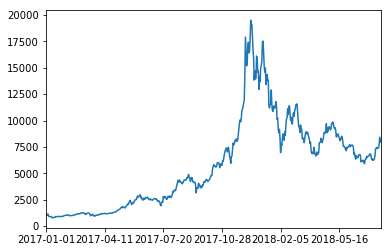

In [46]:
cripto_currencies_pd['ccurr_bitcoin_close'].plot()

** *Diff* or First order Derived Series: Making the series stationary in trend**

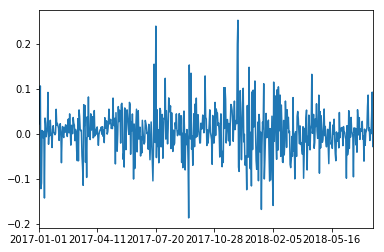

In [47]:
get_returns_in_percent(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

**Most of the time series models works with $r_t$ (spin term??) rather than $R_t$. So by applying the $r_t$ function defined above, we obtain:**

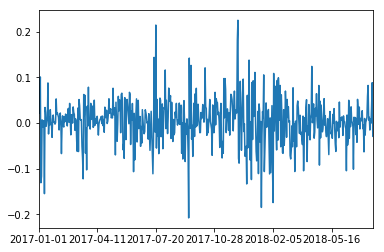

In [48]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

In [49]:
get_returns_in_percent(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023459,0.025704,NaN,0.031042,-0.008951,NaN,0.026798,-0.001612,0.14889,NaN,NaN,0.0,NaN,0.051647


In [50]:
get_rate_return(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023188,0.025379,NaN,0.03057,-0.008991,NaN,0.026445,-0.001614,0.138797,NaN,NaN,0.0,NaN,0.050358


**OBS:** Despite the similarity in the plots above, returns and return rates are sighlty different from each other. 

** Checking the time series distribution, we get a normal distribution **

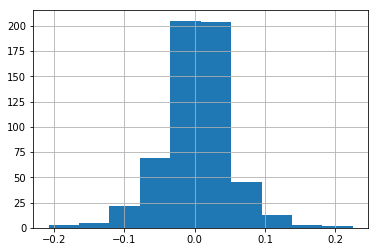

In [51]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].hist()

### Merging Data and filling NaN values

NaN values are in the dataframe due several assets (some cryptocurrencies mainly) have not got a long track closing price history. Such as the case with Cardano and Bit Coin Cash, the first one mentioned for instance has history starting from 13-10-2017 only, hence it is assumed there was not any variance in closing prices difference percent (already differentiated series) before that point filling such missing values with 0. This applies also for None values along the data.

In [54]:
# Stocks percent returns
percent_stocks_returns = get_returns_in_percent(stock_prices_pd)
percent_stocks_returns = percent_stocks_returns.fillna(0)
stock_return_rates = get_rate_return(stock_prices_pd)
stock_return_rates = stock_return_rates.fillna(0)

# Criptocurrencies percent returns
percent_cripto_returns = get_rate_return(cripto_currencies_pd)
percent_cripto_returns = percent_cripto_returns.fillna(0)
ccurr_return_rates = get_rate_return(cripto_currencies_pd)
ccurr_return_rates = ccurr_return_rates.fillna(0)

# Merged DF
portafolio_pd = stock_prices_pd.join(cripto_currencies_pd, how = 'inner')
percent_returns_pd = get_rate_return(portafolio_pd)
percent_returns_pd = percent_returns_pd.fillna(0)
return_rates_pd = get_rate_return(portafolio_pd)
return_rates_pd = return_rates_pd.fillna(0)

# Descriptive analysis


**Negative correlation between sotck and cryptocurrencies markets**: Some experts stand of the hyphothesis there is a weak negative correlation between criptocurrencies returns and stock market assets returns regarding FEAR index cotation, it means when there exists hihgher expeculation and fear in markets such as criptocurrencies, the subjective risk is transferred to stocked market.

It is showed in the heat map below with negative (although unexisting sometimes) correlation between the majority of cryptocurrencies and stocks.

In order to appreciate such phenomena, a heatmap showing correlations between all the assets considered is calculated.

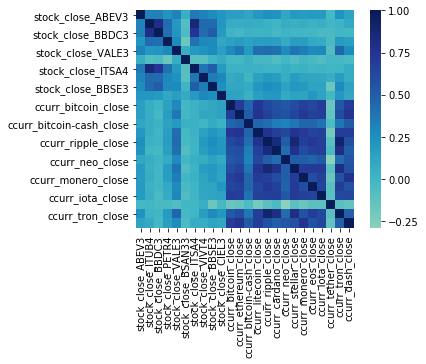

In [55]:
## Pearson correlation - All portafolio
sns.heatmap(percent_returns_pd.tail(360).corr(method='pearson'),  cmap="YlGnBu", center=0, square=True)

The behaviour described in the hypthotesis above, is showed in the data as well, menaning it works also for Brazilian stock assets.

## GARCH models - Getting return value of an asset by using 

**OBS: ** Whenever a GARCH Model does not converge, it is used the mean of the series instead considering recomendations done by some literature regarding the subject, such as (dell course).
"when the data is to messy or may not be able to fit a medium/high complexity model, working with the expected value or mean turns out a better option".

In [56]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

from arch import arch_model

def fit_garch(TS, p_range = 2, o_range = 0, q_range = 2, dist = "StudentsT"):
    dict_temp = {}
    best_aic = None
    best_order = None
    best_model = None
    for p in range(p_range+1):
        for o in range(o_range+1):
            for q in range(q_range+1):
                try:
                    am = arch_model(TS, p=p, o=o, q=q, dist = 'StudentsT')
                    res = am.fit(update_freq=5, disp='off')
                    tmp_aic = res.aic

                    if best_aic is None:
                        best_aic = tmp_aic
                    if tmp_aic <= best_aic:
                        dict_temp = {'best_aic' : tmp_aic, 'results' : res.forecast().mean.iloc[-1]}
                except:
                    if 'best_aic' not in dict_temp:
                        dict_temp = {'best_aic' : 9999999, 'results' : TS.mean() }
                    continue
    return dict_temp


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


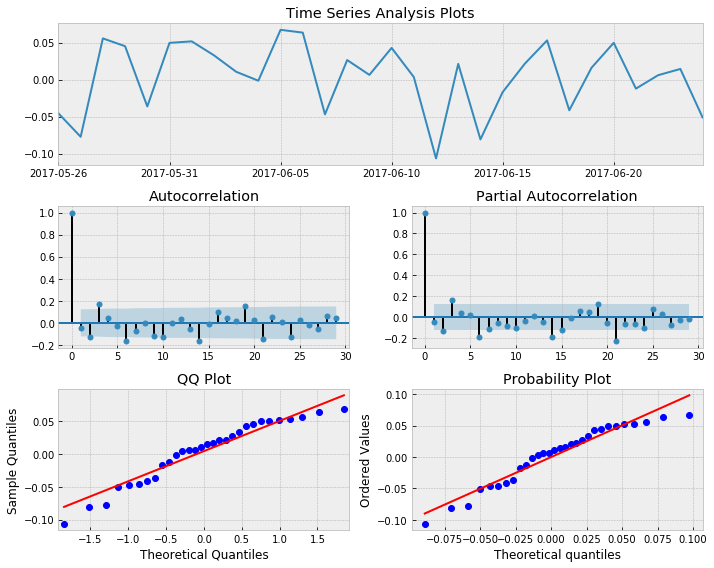

In [61]:
tsplot(ccurr_return_rates[145: 175]['ccurr_bitcoin_close'])

In [58]:
# Testing
test_returned = ccurr_return_rates[145: 175].apply(lambda col: fit_garch(col)['results'])
test_returned

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encou

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
h.1,0.004045,0.003822,0.0,0.006162,-0.010336,0.0,0.020073,0.001322,0.003072,0.0,-0.000013,-0.000688,0.0,0.014683


Considering expression: 

$$ R_t = {e^{r_t}} - 1 $$

In [62]:
# Slighlty different from the previous one, but different anyway
test_returned.apply(lambda col: (np.exp(col) - 1))

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
h.1,0.004054,0.00383,0.0,0.006181,-0.010283,0.0,0.020276,0.001323,0.003077,0.0,-0.000013,-0.000688,0.0,0.014791


## Drawing Markowitz efficient frontier


Different from other proposals, this method will take advantage of the already simulated portafolios, trying to reach for the maximum return at each fixed risk value.

For this, it is supposed that the portfolio with the maximum return and te portafolio with the minimal risk belong to the Markowitz efficient frontier, furthermore these ones may allow us to determine the interval of risk values within the quoted frontier. 

### OBS:

When simulating with genetic algorithims, there is a possibility of some portafolios may not match pre-fixed risk value. Furthemore there is a chance than a portafolio with a very close risk of any of the pre-fixed ones, may have a higher return value.

In order to minimize the effect of such issues, the efficient Markowithz frontier is going to be composed by the portafolios with the maximum return within an interval of +- 0.1 per each risk pre-fixed risk point. 

In [63]:
def return_risk_interval(df, number_of_steps = 5): 
    max_return = df.loc[df['return'] == max(df['return'])]
    min_risk = df.loc[df['risk'] == min(df['risk'])]

    delta = (max_return.iloc[0]['risk'] - min_risk.iloc[0]['risk']) / float(number_of_steps)
    if delta == 0:
        delta = 0.00001
    steps = list()

    for i in list(range(0,number_of_steps + 1)):
        if i == 0:
            steps.append(min_risk.iloc[0]['risk'])
        else:
            steps.append(steps[i-1] + delta)

    return [tuple([i-(delta*0.45), i+(delta*0.45)]) for i in steps] # 0,45 * delta guaranties interval overlapping does not Occur  

def drawing_frontier(df):
    steps_risk_interval = return_risk_interval(df)
    frontier = pd.DataFrame()
    for interval in steps_risk_interval:
        sliced_df = df.loc[(df['risk'] > interval[0])&(df['risk'] < interval[1])]

        if len(sliced_df) == 0: # If this condition is True, means for such interval, does not exist a solution.
            continue
            
        max_return_in_interval = max(sliced_df['return'])
        optimal_interval_portafolio = df.loc[df['return'] == max_return_in_interval].iloc[[0]]
        frontier = pd.concat([frontier, optimal_interval_portafolio])
    
    return frontier

# Call to execute
#frontier = drawing_frontier(df_ga_stock_output)  
#sns.lmplot(x="risk", y="distribution_return", data=frontier, fit_reg=True)


### From the portfolios within Markowitz efficient frontier, Ratio Sharpe is the measure that will allow to pick the best one.

According to (EAFIT reference), the most known investement startegies are:

** The equal wiehgt strategy:** Is one of the most used strategy in portfolio diversification due its simplicity in implementation and understading. It simply weights every stock in a portfolio equally.

** Minimum variance strategy:** Based on Markoweitz portfolio optimizatoin model, from the optimizied portfolios set, the portafolio with the minimum value of variance is selected.

** Mean variance straegy:** Once the Markowitz efficient frontier is calculated, Ratio of Sharpe will lead to significant clues about what portfolio may be the best one when the investor does not have a clear idea about the level of risk he would tolerate.

As sawn since the beginning of this work, the model presented in this work includes the last two.

Once the Markowitz frotnier is drawn, an investor is capable to pick the risk he will tolerate considering the probable return the portfolio might offer. But in many cases, if not the most, evaluate in which level of risk is desired to operate could result difficult to do.

Therefore, the ratio of sharpe is introduced as an helpful criterion to overcome such difficulties.  

This metric considers a free-risk asset in order to involve cost of opportunity (similar to ROI value).



$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma} $$

$$ Where \ \sigma = \sqrt{Variance(𝑟_𝑝 − 𝑟_𝑓)} ; if \ 𝑟_𝑓 \ is \ risk-free, \ then: 𝜎 = 𝜎_𝑝 $$

Finally 

$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma_p} $$



Further work could be leverage towards testing a modified Ratio of Sharpe considering VaR instead of the portfolio variance. This remains out of the scope of this work due it was demostrated that using either the normal Ratio of Shape or the modified Ratio of Shape, does not represent any significant gain in deveolping markets such as the Colombian one where the volatility is higher. This scenario is different in already developed markets such as the american where using VaR instead of variance does delivers siginificant improvements, therefore testing how this modified version of such ratio works in the Brazilian market, is a future work.

For the sake of simplicity it is assumed that Brazilian market and Colombian market are more similar to each other in terms of volatility compared with the similarity between American and Brazilian market in the same context.


$$ Modified \ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{𝑉𝑎𝑅} $$


In [64]:
def get_free_risk_asset_return(annual_rate=0.4, investment_period_in_days=30):
    daily_rate = (1.0+annual_rate)**(1.0/360.0) - 1.0
    free_risk_asset_return = 1
    for i in range(0, investment_period_in_days):
        free_risk_asset_return = free_risk_asset_return + (free_risk_asset_return * daily_rate)
        
    return free_risk_asset_return - 1
    
    
# Ratio of sharpe
def get_ratio_of_sharpe(weights, input_df, free_risk_asset_return):
    
    returns_portafolio = input_df.mean().dot(weights)
    std_portafolio = input_df.cov().dot(weights).dot(weights) ** 0.5

    return (returns_portafolio - free_risk_asset_return) / std_portafolio

## Random simulations - Workflow Example

A random simulation sets random values to the weights according to a given ditribution, gaussian mainly.

In [65]:
# test
def get_train_test_data(pd_dataframe, train_data_size):
    df_size = len(pd_dataframe.index)
    return pd_dataframe[0:df_size*train_data_size], pd_dataframe[df_size*train_data_size, df_size]

# Objective function using means for calculating returns
def random_simulations(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_mean = return_df.mean() # Optimizes the process by calculating this just once
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_mean.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Objective function using GARCH for calculating returns
def random_simulations_using_garch(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_predict = return_rate_df.apply(lambda col: fit_garch(col)['results']) # Optimizes the process by calculating this just once
    returns_predict = returns_predict.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_predict.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Simulate portfolios method
def simulate_portafolios(function, lag = 0, window_time = 60, n = 1000):
    
    tail = len(percent_returns_pd.index)
    
    # Stocks only portafolio
    map_test = function(percent_stocks_returns[tail - (lag + window_time): tail - lag], 
                        stock_return_rates[tail - (lag + window_time): tail - lag],
                        n)
    print('stocks.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_stock_df = pd.DataFrame(map_test)
    simulations_stock_df['portafolio_type'] = ['stock_only' for i in simulations_stock_df.index]

    # Criptocurrencies only portafolio
    map_test = function(percent_cripto_returns[tail - (lag + window_time): tail - lag], 
                        ccurr_return_rates[tail - (lag + window_time): tail - lag], 
                        n)
    print('ccurr.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_ccur_df = pd.DataFrame(map_test)
    simulations_ccur_df['portafolio_type'] = ['ccurr_only' for i in simulations_ccur_df.index]

    # Total portafolio
    map_test = function(percent_returns_pd[tail - (lag + window_time): tail - lag],
                        return_rates_pd[tail - (lag + window_time): tail - lag],
                        n)
    print('mixed.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_df = pd.DataFrame(map_test)
    simulations_df['portafolio_type'] = ['mixed_assets' for i in simulations_df.index]
    
    return simulations_stock_df, simulations_ccur_df, simulations_df


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

stocks.. init: 427 end: 457


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

ccurr.. init: 427 end: 457


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

mixed.. init: 427 end: 457


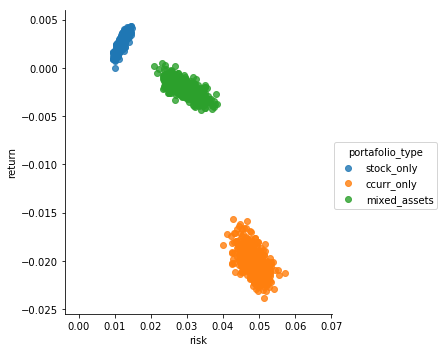

In [66]:
# Simulating Portfolios 
lag, window_time = 0, 30

# With mean
#simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations, lag, window_time,500)

# With Garch
simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations_using_garch, lag, window_time,500)

simulation_frames = [simulations_stock_df, simulations_ccur_df, simulations_df]
simulations_concatenated = pd.concat(simulation_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

*** Drawing Markowitz efficient frontier ***

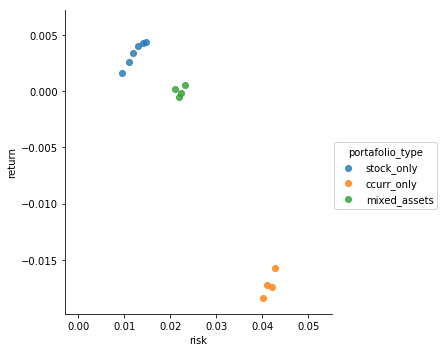

In [67]:
stock_frontier = drawing_frontier(simulations_stock_df)
ccur_frontier = drawing_frontier(simulations_ccur_df)
mixed_frontier = drawing_frontier(simulations_df)

summarized_frontiers = [stock_frontier, ccur_frontier, mixed_frontier]
summarized_frontiers = pd.concat(summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_frontiers, fit_reg=False)

In [68]:
stock_frontier

,assets,index,return,risk,weights,portafolio_type
121,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",121,0.001642,0.009553,"[0.143682300111, 0.194959339178, 0.02908233934...",stock_only
317,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",317,0.002582,0.010921,"[0.124563674021, 0.0683350784309, 0.1219023209...",stock_only
29,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",29,0.003402,0.011798,"[0.104109602595, 0.14815170995, 0.134120728149...",stock_only
160,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",160,0.004020,0.012897,"[0.136151845278, 0.208302899373, 0.03278551007...",stock_only
277,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",277,0.004265,0.013961,"[0.0643680137785, 0.215263650245, 0.1807285187...",stock_only
392,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",392,0.004377,0.014584,"[0.0893922222839, 0.152593151624, 0.1445131775...",stock_only


*** Ratio of Sharpe ***

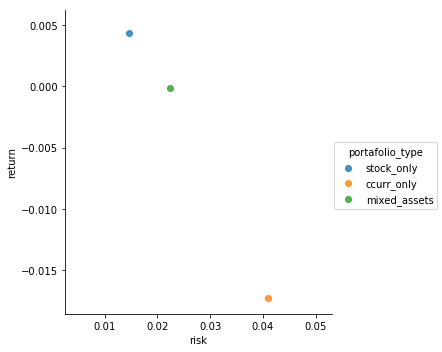

In [69]:
free_risk_asset = get_free_risk_asset_return(0.4, window_time)

# Calcuating ratio of sharpe of each asset belonging to the markwitz frontier

stock_frontier['ratio_of_sharpe'] = stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, free_risk_asset) , axis = 1)
ccur_frontier['ratio_of_sharpe'] = ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, free_risk_asset) , axis = 1)
mixed_frontier['ratio_of_sharpe'] = mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, free_risk_asset) , axis = 1)


# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = stock_frontier.loc[stock_frontier['ratio_of_sharpe'] == max(stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ccur_frontier.loc[ccur_frontier['ratio_of_sharpe'] == max(ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  mixed_frontier.loc[mixed_frontier['ratio_of_sharpe'] == max(mixed_frontier['ratio_of_sharpe'])]

# Ploting
summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

# Optimization with Genetic Algorithms

***OBS: *** Few data with a linear Opt. Function (substraction) tend to fall in local "maximus" (higher probabiity of exploit). Whereas a non-linear F.O. apparently does not.

### GA functions declaration

In [70]:
'''
@article{DEAP_JMLR2012, 
    author    = " F\'elix-Antoine Fortin and Fran\c{c}ois-Michel {De Rainville} and Marc-Andr\'e Gardner and Marc Parizeau and Christian Gagn\'e ",
    title     = { {DEAP}: Evolutionary Algorithms Made Easy },
    pages    = { 2171--2175 },
    volume    = { 13 },
    month     = { jul },
    year      = { 2012 },
    journal   = { Journal of Machine Learning Research }
'''

############### GA Implementation #############

def run_ga(percent_returns_pd, rate_returns_pd, use_garch = False):
    
    from deap import creator, base, tools, algorithms
    
    #Selecting which method should be used for calculating the returns by asset 
    if use_garch is False:
        returns = percent_returns_pd.mean()
        returns_cov = percent_returns_pd.cov()
    else:
        returns = rate_returns_pd.apply(lambda col: fit_garch(col)['results'])
        returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
        returns_cov = percent_returns_pd.cov()
    
    # Objective function
    def objective_function(individual):
        if sum(individual) == 0:
            total = 1e-2
        else:
            total = sum(individual)
        w = np.divide(individual, total)
        return_portafolio = returns.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        return (return_portafolio / std_portafolio,) 
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    num_assets = len(percent_returns_pd.columns)
    toolbox = base.Toolbox()
    toolbox.register("attr_flt", random.uniform, 0.001, 0.999)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_flt, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", objective_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    
    # Run GA
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    top10 = tools.selBest(population, k=10)
    return top10,pop, log, stats


############ Outputs processing ##############

def get_portafolio_stats(df_input, resource_optimal_distr):    
    average_close_portafolio = df_input.mean()
    cov_portafolio = df_input.cov()
    optimal_distr = resource_optimal_distr
    optimal_percentuals = np.divide(optimal_distr, sum(optimal_distr))
    return_in_percent = average_close_portafolio.dot(optimal_percentuals)
    risk_in_percent = cov_portafolio.dot(optimal_percentuals).dot(optimal_percentuals) ** 0.5
    return return_in_percent, risk_in_percent, resource_optimal_distr


## GA optimization - Workflow Example

***OBS:*** Experiments regarding the optimal number of assets are out of the scope of this work. Such number is defined by the premises adopted since the beginning. 
Considering the most signifcant companies/criptocurrencies according of its size. Companies with a minimum of 80% percent of summarized market capital.


In [71]:
def execute_by_interval(lag = 0, window_time = 30, is_garch = False):    
    
    tail = len(percent_returns_pd.index)
    
    # Stock only
    top10_stock, pop_stock, log_stock, stas_stock = run_ga(percent_stocks_returns[tail - (lag + window_time): tail - lag],
                                                           stock_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_stock:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_stocks_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_stock_output = pd.DataFrame.from_records(stats) 
    df_ga_stock_output.columns = ['return', 'risk', 'weights']
    df_ga_stock_output['portafolio_type'] = ['stock_only' for i in df_ga_stock_output.index]

    # Cripto Currencies only
    top10_ccurr, pop_ccurr, log_ccurr, stas_ccurr = run_ga(percent_cripto_returns[tail - (lag + window_time): tail - lag],
                                                           ccurr_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_ccurr:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_cripto_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_ccur_output = pd.DataFrame.from_records(stats) 
    df_ga_ccur_output.columns = ['return', 'risk', 'weights']
    df_ga_ccur_output['portafolio_type'] = ['ccurr_only' for i in df_ga_ccur_output.index]
    
    top10, pop, log, stas = run_ga(percent_returns_pd[tail - (lag + window_time): tail - lag],
                                   return_rates_pd[tail - (lag + window_time): tail - lag],
                                   is_garch)
    stats = []
    for individual in pop:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_returns_pd[tail - (lag + window_time): tail - lag], pop))
    df_ga_output = pd.DataFrame.from_records(stats) 
    df_ga_output.columns = ['return', 'risk', 'weights']
    df_ga_output['portafolio_type'] = ['mixed_assets' for i in df_ga_output.index]
    
    return df_ga_stock_output, df_ga_ccur_output, df_ga_output

In [72]:
# Exectuing optimization using means with returns

# Using mean for returns    
#df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, False)

# Using Garch for returns
df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, True)

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

gen	nevals	avg    	std      	min      	max     
0  	1000  	0.21835	0.0467245	0.0542301	0.332095
1  	591   	0.2547 	0.0446361	-0.0348374	0.368495
2  	602   	0.280293	0.040946 	0.0409051 	0.367603
3  	603   	0.300987	0.0466716	-0.0561165	0.364716
4  	588   	0.320123	0.0376314	0.0724137 	0.367644
5  	575   	nan     	nan      	nan       	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


6  	624   	nan     	nan      	nan       	nan     
7  	603   	0.340417	0.0532777	-0.0377417	0.370472
8  	574   	0.344591	0.0490928	-0.000546336	0.370472
9  	583   	0.344785	0.0545347	-0.0113825  	0.370551
10 	648   	0.347722	0.0513574	-0.0550237  	0.371145
11 	608   	0.34737 	0.0559417	-0.0561613  	0.371203
12 	595   	0.344009	0.0633396	-0.0820576  	0.371776
13 	604   	0.34085 	0.0701819	-0.0643236  	0.373182
14 	626   	0.342587	0.0735039	-0.279112   	0.373182
15 	618   	0.34804 	0.0610276	-0.143306   	0.373244
16 	601   	0.351149	0.0553743	-0.0371369  	0.373343
17 	584   	nan     	nan      	nan         	nan     
18 	601   	0.344015	0.0689727	-0.223545   	0.373475
19 	604   	0.348141	0.0586882	-0.00850078 	0.37363 
20 	603   	0.34703 	0.0651934	-0.102414   	0.37363 
21 	585   	0.34577 	0.0702097	-0.182965   	0.37363 
22 	596   	nan     	nan      	nan         	nan     
23 	641   	0.341178	0.0747165	-0.269925   	0.37363 
24 	615   	nan     	nan      	nan         	nan     
25 	617   	nan  

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.416609	0.0224874	-0.493661	-0.349343
1  	574   	-0.397195	0.0225642	-0.485969	-0.316179
2  	578   	-0.378582	0.0245586	-0.542426	-0.290934
3  	600   	-0.361061	0.0285555	-0.515211	-0.239117
4  	604   	-0.344058	0.0326784	-0.583491	-0.215102
5  	560   	-0.327151	0.0380438	-0.521503	-0.209257
6  	615   	-0.312063	0.043687 	-0.549433	-0.18059 
7  	625   	-0.292792	0.049207 	-0.560853	-0.144038
8  	584   	-0.274954	0.0561069	-0.517985	-0.116436
9  	608   	-0.252836	0.0630055	-0.51824 	-0.113898
10 	611   	-0.232529	0.0674478	-0.524357	-0.113898
11 	586   	-0.221561	0.0844516	-0.614736	-0.000885096
12 	642   	-0.205353	0.0880798	-0.504268	-0.000885096
13 	608   	-0.192876	0.0954473	-0.635775	-0.000885096
14 	633   	-0.177176	0.102223 	-0.642963	-0.000885096
15 	577   	-0.171364	0.110134 	-0.567594	-0.000885096
16 	604   	nan      	nan      	nan      	nan         
17 	587   	nan      	nan      	nan      	nan         


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


18 	573   	nan      	nan      	nan      	nan         
19 	606   	nan      	nan      	nan      	nan         
20 	635   	nan      	nan      	nan      	nan         
21 	609   	nan      	nan      	nan      	nan         
22 	604   	nan      	nan      	nan      	nan         
23 	613   	nan      	nan      	nan      	nan         
24 	605   	nan      	nan      	nan      	nan         
25 	635   	nan      	nan      	nan      	nan         
26 	625   	nan      	nan      	nan      	nan         
27 	594   	nan      	nan      	nan      	nan         
28 	579   	nan      	nan      	nan      	nan         
29 	608   	nan      	nan      	nan      	nan         
30 	563   	nan      	nan      	nan      	nan         
31 	617   	nan      	nan      	nan      	nan         
32 	641   	nan      	nan      	nan      	nan         
33 	593   	nan      	nan      	nan      	nan         
34 	592   	nan      	nan      	nan      	nan         
35 	599   	nan      	nan      	nan      	nan         
36 	631   	nan      	nan    

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std      	min      	max     
0  	1000  	-0.0691551	0.0234523	-0.137072	0.025492
1  	565   	-0.0483924	0.0252607	-0.141262	0.0951169
2  	599   	-0.0298198	0.0283982	-0.13001 	0.130837 
3  	623   	-0.00786286	0.0376128	-0.136169	0.20264  
4  	624   	0.0148773  	0.0459488	-0.169345	0.200492 
5  	588   	0.0428568  	0.0545493	-0.145708	0.272106 
6  	633   	0.069199   	0.0590989	-0.139902	0.272106 
7  	583   	0.0951027  	0.0715426	-0.161046	0.326679 
8  	615   	0.118875   	0.0827479	-0.127224	0.329369 
9  	622   	0.150139   	0.0925434	-0.133057	0.377309 
10 	560   	0.17691    	0.102969 	-0.155752	0.377309 
11 	584   	0.20181    	0.114543 	-0.175208	0.38025  
12 	573   	0.229925   	0.12342  	-0.132105	0.390193 
13 	603   	0.244136   	0.137419 	-0.161499	0.385209 
14 	623   	0.261775   	0.137658 	-0.137284	0.395451 
15 	589   	0.273399   	0.144096 	-0.139435	0.395736 
16 	629   	0.272167   	0.156629 	-0.14997 	0.396239 
17 	560   	0.290267   	0.152953 	-0.151357	0.401419 

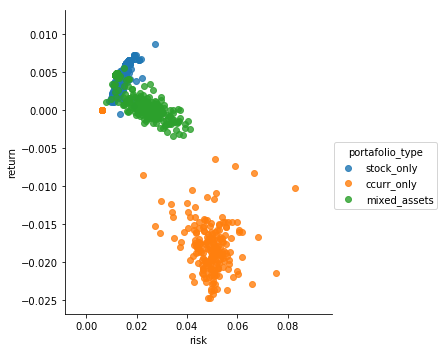

In [75]:
simulation_ga_frames = [df_ga_stock_output, df_ga_ccur_output, df_ga_output]
simulations_ga_concatenated = pd.concat(simulation_ga_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_ga_concatenated, fit_reg=False)

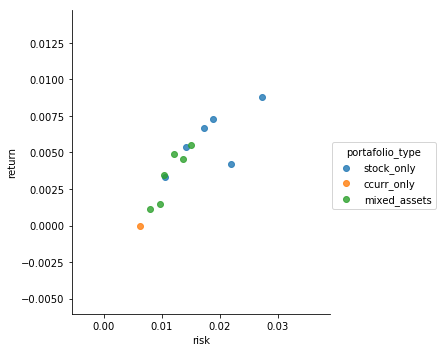

In [76]:
ga_stock_frontier = drawing_frontier(df_ga_stock_output)
ga_ccur_frontier = drawing_frontier(df_ga_ccur_output)
ga_mixed_frontier = drawing_frontier(df_ga_output)

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
pre_fixed_time_window = 5
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

ga_summarized_frontiers = [ga_stock_frontier, ga_ccur_frontier, ga_mixed_frontier]
ga_summarized_frontiers = pd.concat(ga_summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=ga_summarized_frontiers, fit_reg=False)

### GA optimization vs Random Simulations

* Looking at the outcome plots of GA and Random simulation respectevaly, the main difference between these both is that GA allows a higher degree of the hyperspace exploration (Hyperspace is defined as the space where the possible silution are located), hence in GA the degree of exploting is lower, which enhaces the searching for global maximums.

* This might not be the case, but for portfolios composed by a signifacnlty higher number of assets, a random simulation dynamic is not suitable due this is considered a NP problem (not polynomial complexity problem in execution time).

## Optimizations(t) 

Once the optmization model is explained, the goal goes towards evaluate the protfolios behaviour in time.


** GA displacing time_window: ** It seeks to evaluate temporal behaviour considering a prefixed time_window displacing lags

In [77]:
tempos = dict()
num_iterations = 10

# Initialy we consider the lag per iteration with the same value of pre_fixed_time_window
lag_step_size, pre_fixed_time_window = 30, 30

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

last_date = percent_returns_pd.index[-1]

for i in range(1,num_iterations+1):
    print((num_iterations-i)*lag_step_size, pre_fixed_time_window)
    df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval((num_iterations-i)*lag_step_size, pre_fixed_time_window, True)
    ga_stock_frontier,ga_ccur_frontier,ga_mixed_frontier = drawing_frontier(df_ga_stock_output), drawing_frontier(df_ga_ccur_output), drawing_frontier(df_ga_output)
   
    ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
    ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
    ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)
    
    partition_date = (datetime.strptime(last_date, '%Y-%m-%d') + relativedelta(days = -((num_iterations-i)*lag_step_size))).strftime('%Y-%m-%d')
    tempos[partition_date] = dict()
    tempos[partition_date]['stock_frontier'] = ga_stock_frontier
    tempos[partition_date]['ccur_frontier'] = ga_ccur_frontier
    tempos[partition_date]['mixed_frontier'] = ga_mixed_frontier

270 30


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been cr

gen	nevals	avg   	std      	min       	max     
0  	1000  	0.1998	0.0613069	-0.0419614	0.351754
1  	618   	0.24516	0.0556722	-0.229595 	0.430035
2  	624   	0.280589	0.046447 	-0.0276436	0.430035
3  	628   	0.305225	0.0465481	0.0453061 	0.442376
4  	598   	0.322577	0.0554696	-0.0620814	0.4515  
5  	593   	0.338655	0.0614414	-0.0537441	0.4515  
6  	663   	0.346799	0.0813079	-0.133538 	0.46878 
7  	576   	0.361079	0.0843277	-0.162206 	0.479654
8  	594   	0.372929	0.0937735	-0.197459 	0.479654
9  	583   	0.382058	0.100728 	-0.183526 	0.480055
10 	628   	0.391644	0.108801 	-0.223456 	0.487447


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


11 	646   	nan     	nan      	nan       	nan     
12 	587   	nan     	nan      	nan       	nan     
13 	617   	nan     	nan      	nan       	nan     
14 	595   	nan     	nan      	nan       	nan     
15 	620   	nan     	nan      	nan       	nan     
16 	620   	nan     	nan      	nan       	nan     
17 	614   	0.432286	0.129749 	-0.15814  	0.500912
18 	613   	0.42066 	0.150953 	-0.223456 	0.50143 
19 	611   	nan     	nan      	nan       	nan     
20 	612   	0.43468 	0.142955 	-0.208446 	0.50143 
21 	596   	0.434723	0.146628 	-0.214105 	0.50143 
22 	596   	0.437715	0.149081 	-0.229405 	0.50143 
23 	573   	0.42718 	0.159182 	-0.248255 	0.50143 
24 	583   	0.439752	0.146831 	-0.215191 	0.50143 
25 	592   	0.439815	0.139053 	-0.20927  	0.50143 
26 	586   	nan     	nan      	nan       	nan     
27 	588   	nan     	nan      	nan       	nan     
28 	595   	nan     	nan      	nan       	nan     
29 	592   	nan     	nan      	nan       	nan     
30 	620   	nan     	nan      	nan       	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0424241	0.0249133	-0.124559	0.0207197
1  	588   	-0.0232748	0.0223871	-0.167715	0.0728482
2  	601   	-0.00580569	0.0222468	-0.13969 	0.120412 
3  	591   	0.00788744 	0.0241475	-0.158415	0.124633 
4  	597   	0.0180769  	0.0322611	-0.189147	0.140194 
5  	635   	0.0320033  	0.0369846	-0.234203	0.158283 
6  	608   	0.0462401  	0.0425753	-0.166374	0.16087  
7  	601   	0.0585012  	0.051577 	-0.218818	0.16087  
8  	596   	0.0738449  	0.0569372	-0.296313	0.160833 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	608   	nan        	nan      	nan      	nan      
10 	585   	nan        	nan      	nan      	nan      
11 	559   	nan        	nan      	nan      	nan      
12 	587   	0.115406   	0.073394 	-0.293289	0.16087  
13 	586   	0.117519   	0.0793202	-0.296122	0.160871 
14 	548   	0.122761   	0.0765554	-0.296122	0.160871 
15 	614   	0.122846   	0.0761811	-0.292045	0.160871 
16 	558   	nan        	nan      	nan      	nan      
17 	602   	0.125316   	0.0777509	-0.296342	0.160871 
18 	601   	0.126183   	0.0768281	-0.296674	0.160871 
19 	588   	0.126704   	0.0731834	-0.213945	0.160871 
20 	645   	0.119417   	0.0810679	-0.226049	0.160871 
21 	585   	nan        	nan      	nan      	nan      
22 	612   	0.127648   	0.0731096	-0.214743	0.160871 
23 	602   	0.125067   	0.078142 	-0.296674	0.160871 
24 	616   	nan        	nan      	nan      	nan      
25 	603   	nan        	nan      	nan      	nan      
26 	615   	nan        	nan      	nan      	nan      
27 	589   	nan        	nan      	nan      	nan

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg     	std      	min       	max     
0  	1000  	0.111874	0.0405624	-0.0136389	0.231805
1  	596   	0.144051	0.0378982	-0.014244 	0.287466
2  	619   	0.171044	0.0419972	-0.0899551	0.318111
3  	590   	0.1977  	0.0471927	-0.0541088	0.324934
4  	594   	0.225627	0.0522957	-0.0652268	0.333189
5  	590   	0.244082	0.0629336	-0.178554 	0.369972
6  	597   	0.26162 	0.0627676	-0.0383462	0.393806
7  	610   	0.270096	0.0780332	-0.16762  	0.426923
8  	636   	0.285936	0.0799761	-0.0599388	0.427988
9  	563   	0.297974	0.0844707	-0.0596965	0.427988
10 	597   	0.311524	0.0885632	-0.0523532	0.453811
11 	597   	0.316405	0.100733 	-0.107503 	0.474976
12 	633   	0.330675	0.106675 	-0.110571 	0.481956
13 	580   	0.340203	0.120959 	-0.153267 	0.496394
14 	615   	0.355068	0.129297 	-0.136271 	0.4973  
15 	602   	0.370604	0.132512 	-0.0570175	0.497472
16 	578   	0.381742	0.141586 	-0.158391 	0.497472
17 	597   	0.389235	0.151084 	-0.0947078	0.497765
18 	593   	0.408929	0.142383 	-0.0878833	0.498418


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std     	min       	max     
0  	1000  	0.0881529	0.043364	-0.0556022	0.216217
1  	592   	0.122263 	0.0388603	-0.0578063	0.275748
2  	628   	0.14996  	0.0410244	-0.0760084	0.288704
3  	578   	0.174754 	0.0449154	-0.175983 	0.310746
4  	580   	nan      	nan      	nan       	nan     
5  	603   	nan      	nan      	nan       	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


6  	591   	0.234503 	0.0617265	-0.167953 	0.337188
7  	621   	0.247524 	0.0666798	-0.149756 	0.337188
8  	580   	0.258945 	0.0710901	-0.150989 	0.337853
9  	628   	0.268017 	0.0745335	-0.174399 	0.337891
10 	574   	0.280614 	0.0724553	-0.06742  	0.337891
11 	589   	0.278589 	0.0879142	-0.149756 	0.337932
12 	616   	0.287319 	0.0869361	-0.138452 	0.337932
13 	625   	0.290572 	0.0876359	-0.109954 	0.337932
14 	610   	0.288152 	0.0973882	-0.124732 	0.337932
15 	611   	nan      	nan      	nan       	nan     
16 	620   	0.292441 	0.09651  	-0.107674 	0.337932
17 	599   	nan      	nan      	nan       	nan     
18 	591   	nan      	nan      	nan       	nan     
19 	604   	nan      	nan      	nan       	nan     
20 	601   	nan      	nan      	nan       	nan     
21 	596   	nan      	nan      	nan       	nan     
22 	579   	nan      	nan      	nan       	nan     
23 	601   	nan      	nan      	nan       	nan     
24 	549   	nan      	nan      	nan       	nan     
25 	621   	nan      	nan      	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  Conver

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg      	std      	min       	max      
0  	1000  	0.0344872	0.0163064	-0.0304119	0.0844846
1  	570   	0.0476286	0.0157216	-0.0623677	0.0969429
2  	591   	0.0579045	0.0168221	-0.0425055	0.119076 
3  	605   	0.0677649	0.0183601	-0.0342065	0.122999 
4  	580   	0.0768585	0.0194041	-0.077473 	0.129548 
5  	608   	0.0833671	0.0227243	-0.0840491	0.140708 
6  	586   	0.0908318	0.0241393	-0.0673031	0.142704 
7  	620   	0.096377 	0.0296613	-0.117223 	0.14562  
8  	579   	0.10293  	0.0316526	-0.0821053	0.145696 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	608   	nan      	nan      	nan       	nan      
10 	599   	nan      	nan      	nan       	nan      
11 	560   	nan      	nan      	nan       	nan      
12 	630   	nan      	nan      	nan       	nan      
13 	601   	0.124129 	0.0418657	-0.118569 	0.148856 
14 	626   	0.125058 	0.0426938	-0.0663812	0.149108 
15 	614   	0.128922 	0.0399603	-0.0781563	0.149641 
16 	608   	0.128234 	0.042512 	-0.110625 	0.149641 
17 	615   	0.127496 	0.0435905	-0.0806684	0.149866 
18 	619   	0.126898 	0.0465051	-0.117223 	0.150259 
19 	597   	0.12843  	0.0441321	-0.118582 	0.150259 
20 	590   	nan      	nan      	nan       	nan      
21 	585   	nan      	nan      	nan       	nan      
22 	617   	nan      	nan      	nan       	nan      
23 	592   	nan      	nan      	nan       	nan      
24 	582   	nan      	nan      	nan       	nan      
25 	593   	0.129673 	0.0446394	-0.116932 	0.15034  
26 	585   	0.129918 	0.0449828	-0.113805 	0.15034  
27 	615   	0.12887  	0.045823 	-0.118728 	0.15034  
28 	588   	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider d

gen	nevals	avg       	std      	min     	max      
0  	1000  	-0.0721877	0.0218595	-0.14162	0.0276135
1  	600   	-0.0535607	0.0215885	-0.146566	0.0415357
2  	591   	-0.0367711	0.0229351	-0.152103	0.0415357
3  	607   	-0.0209392	0.0255599	-0.132663	0.054007 
4  	600   	-0.00468311	0.0295496	-0.141114	0.100738 
5  	571   	0.00965115 	0.0347473	-0.159839	0.119333 
6  	626   	0.0223895  	0.0417488	-0.183393	0.157904 
7  	609   	0.0385746  	0.0436534	-0.159174	0.167555 
8  	582   	0.0507547  	0.0546928	-0.158543	0.177872 
9  	585   	0.0641437  	0.061074 	-0.150637	0.205575 
10 	621   	0.0793494  	0.0663132	-0.18641 	0.2243   
11 	610   	0.0950676  	0.0734478	-0.182459	0.268922 
12 	584   	0.11036    	0.0845765	-0.180709	0.284111 
13 	590   	0.123819   	0.0976282	-0.197402	0.305698 
14 	608   	0.146845   	0.100247 	-0.210087	0.305698 
15 	587   	0.162329   	0.110805 	-0.184061	0.305698 
16 	627   	0.16911    	0.12376  	-0.1997  	0.316986 
17 	604   	0.184788   	0.129279 	-0.19957 	0.316986 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


38 	583   	0.265972   	0.166961 	-0.217808	0.350423 
39 	624   	0.25978    	0.174269 	-0.209206	0.350423 
40 	596   	0.268226   	0.167284 	-0.202095	0.350423 
210 30


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max       
0  	1000  	-0.100686	0.0340196	-0.212475	0.00334253
1  	609   	-0.0729766	0.033752 	-0.256098	0.033184  
2  	599   	-0.0481843	0.0336224	-0.230108	0.0517416 
3  	606   	-0.0288859	0.0372011	-0.250645	0.0597958 
4  	569   	-0.0107791	0.0374931	-0.312257	0.0675986 
5  	648   	0.00260164	0.0413379	-0.260373	0.0675986 
6  	591   	0.0171297 	0.0406187	-0.252865	0.0770705 
7  	620   	nan       	nan      	nan      	nan       
8  	590   	nan       	nan      	nan      	nan       


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	650   	nan       	nan      	nan      	nan       
10 	604   	0.0381802 	0.0571882	-0.295511	0.0770705 
11 	572   	nan       	nan      	nan      	nan       
12 	632   	nan       	nan      	nan      	nan       
13 	616   	nan       	nan      	nan      	nan       
14 	614   	nan       	nan      	nan      	nan       
15 	614   	nan       	nan      	nan      	nan       
16 	579   	nan       	nan      	nan      	nan       
17 	569   	nan       	nan      	nan      	nan       
18 	600   	nan       	nan      	nan      	nan       
19 	621   	nan       	nan      	nan      	nan       
20 	577   	nan       	nan      	nan      	nan       
21 	623   	nan       	nan      	nan      	nan       
22 	611   	nan       	nan      	nan      	nan       
23 	599   	nan       	nan      	nan      	nan       
24 	591   	nan       	nan      	nan      	nan       
25 	608   	nan       	nan      	nan      	nan       
26 	582   	nan       	nan      	nan      	nan       
27 	603   	nan       	nan      	nan      	nan 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: inva

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg       	std      	min     	max    
0  	1000  	-0.0376266	0.0405377	-0.17416	0.10452
1  	621   	-0.00256531	0.0423635	-0.171916	0.287109
2  	585   	0.02805    	0.0446744	-0.19179 	0.220566
3  	624   	0.0564347  	0.0462544	-0.180998	0.227861
4  	600   	0.0845846  	0.0545051	-0.176111	0.275365
5  	593   	0.110117   	0.0609776	-0.21068 	0.270008
6  	570   	0.136222   	0.0617869	-0.169293	0.270008
7  	605   	0.156571   	0.0686974	-0.174925	0.270008
8  	604   	0.169894   	0.0775644	-0.177237	0.270008
9  	577   	0.179253   	0.0877842	-0.194569	0.271379
10 	621   	0.191199   	0.0873429	-0.153677	0.273549
11 	576   	0.194568   	0.102224 	-0.21912 	0.285504
12 	570   	0.209037   	0.100091 	-0.236846	0.285504
13 	590   	0.208927   	0.109678 	-0.196144	0.291204


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


14 	605   	nan        	nan      	nan      	nan     
15 	575   	nan        	nan      	nan      	nan     
16 	591   	nan        	nan      	nan      	nan     
17 	592   	nan        	nan      	nan      	nan     
18 	594   	0.231579   	0.12362  	-0.185503	0.315723
19 	616   	nan        	nan      	nan      	nan     
20 	610   	nan        	nan      	nan      	nan     
21 	598   	nan        	nan      	nan      	nan     
22 	597   	0.234176   	0.145276 	-0.225605	0.317361
23 	590   	nan        	nan      	nan      	nan     
24 	586   	nan        	nan      	nan      	nan     
25 	596   	0.246857   	0.146002 	-0.192228	0.317361
26 	622   	0.23697    	0.155218 	-0.260169	0.317361
27 	617   	0.245739   	0.146008 	-0.199966	0.317361
28 	596   	0.245096   	0.147957 	-0.199966	0.317361
29 	572   	0.241601   	0.152442 	-0.229199	0.317361
30 	606   	nan        	nan      	nan      	nan     
31 	621   	0.240965   	0.154018 	-0.255473	0.317361
32 	590   	0.246477   	0.151274 	-0.2277  	0.317361
33 	611   	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min       	max     
0  	1000  	0.0996954	0.0346625	0.00413763	0.210154
1  	596   	0.127317 	0.0341015	-0.0207089	0.311843
2  	601   	0.151978 	0.0370315	-0.00293255	0.346107
3  	607   	0.172467 	0.046185 	-0.0295893 	0.376793
4  	643   	0.196107 	0.0534582	-0.0703298 	0.390331
5  	604   	0.221578 	0.0610056	-0.0690327 	0.38971 
6  	603   	0.244697 	0.0697598	-0.00513981	0.425907
7  	592   	0.272156 	0.0720697	0.0142002  	0.427296
8  	615   	0.296358 	0.0821483	-0.0443919 	0.444748
9  	626   	0.313132 	0.0939298	-0.0393071 	0.465809
10 	622   	0.329661 	0.0979318	-0.0217953 	0.476438
11 	620   	0.341426 	0.106832 	-0.0643234 	0.482326
12 	570   	0.359865 	0.106684 	-0.00550798	0.499569
13 	604   	0.374187 	0.116002 	-0.0385434 	0.529981
14 	551   	0.386268 	0.124204 	-0.0352597 	0.529981
15 	572   	0.402518 	0.124841 	-0.0713878 	0.533154
16 	586   	0.416354 	0.130094 	-0.0420056 	0.539099
17 	596   	0.419725 	0.140931 	-0.0761917 	0.545476
18 	587   	0.43

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std       	min      	max     
0  	1000  	0.103787	0.00739957	0.0764872	0.127411
1  	607   	0.109301	0.00745842	0.0660415	0.131962
2  	633   	0.114337	0.00752387	0.0347739	0.133897
3  	588   	0.117991	0.00796897	0.0369764	0.137266
4  	572   	0.121389	0.00816726	0.0358711	0.139411
5  	603   	0.123608	0.00948626	0.0419849	0.139411
6  	619   	0.125469	0.0103435 	0.0117338	0.139411
7  	605   	0.127443	0.0108381 	0.0217214	0.139411
8  	606   	0.127547	0.0138647 	0.0123762	0.139411
9  	577   	0.128905	0.0147203 	0.0127826	0.140056
10 	654   	0.130423	0.0128088 	0.0449077	0.140004
11 	650   	0.13109 	0.014272  	0.0117338	0.140125
12 	634   	0.132751	0.0131469 	0.0367542	0.140168
13 	605   	0.13212 	0.0151956 	0.0425717	0.140293
14 	613   	0.132517	0.0162714 	0.0117338	0.140361
15 	597   	0.133119	0.0156001 	0.0463911	0.140361
16 	609   	0.133176	0.0156041 	0.0393519	0.140361
17 	572   	0.133181	0.0164217 	0.00950591	0.140395
18 	588   	0.132826	0.0175564 	0.0117338 	0.14039

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


21 	615   	0.13448 	0.0145572 	0.0487966 	0.140433
22 	573   	0.133576	0.0156244 	0.0591507 	0.140433
23 	625   	0.133458	0.0165193 	0.00933784	0.140433
24 	633   	0.1326  	0.01692   	0.0349342 	0.140433
25 	592   	0.133812	0.0157704 	0.002216  	0.140433
26 	569   	0.133451	0.0157079 	0.049713  	0.140435
27 	570   	nan     	nan       	nan       	nan     
28 	565   	0.13351 	0.0161987 	0.00950591	0.140435
29 	630   	0.132888	0.0166213 	0.0349342 	0.140435
30 	595   	0.134063	0.0153529 	0.041617  	0.140435
31 	620   	0.133927	0.0158076 	0.0416204 	0.140435
32 	585   	0.133572	0.0155515 	0.0117338 	0.140435
33 	569   	0.13274 	0.0169517 	0.0531109 	0.140435
34 	557   	0.134323	0.014884  	0.0561306 	0.140435
35 	588   	0.133919	0.0159879 	0.00953437	0.140435
36 	605   	0.134522	0.0145793 	0.0531109 	0.140435
37 	583   	0.133511	0.0158991 	0.0592864 	0.140435
38 	637   	0.13442 	0.0142843 	0.0349402 	0.140435
39 	609   	0.133131	0.0165903 	0.00953437	0.140435
40 	579   	0.13345 	0.0165195 	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min       	max      
0  	1000  	-0.0419753	0.0154358	-0.0853718	0.0122418
1  	586   	-0.0286395	0.0162211	-0.121454 	0.0701677
2  	632   	-0.0165479	0.017045 	-0.0874576	0.0895805
3  	567   	-0.00411357	0.0182501	-0.104926 	0.0895805
4  	610   	0.00645711 	0.0229422	-0.142969 	0.167038 
5  	645   	0.0161536  	0.0257625	-0.119007 	0.167038 
6  	618   	0.0276879  	0.0306955	-0.118047 	0.186095 
7  	567   	0.0391359  	0.0379167	-0.134773 	0.219585 
8  	588   	0.056991   	0.0442361	-0.0941373	0.278535 
9  	624   	0.0719202  	0.060901 	-0.133361 	0.278535 
10 	631   	0.0990761  	0.0746825	-0.122865 	0.278535 
11 	566   	0.128663   	0.0860582	-0.121851 	0.280968 
12 	614   	0.150472   	0.102408 	-0.148671 	0.28168  
13 	592   	0.179889   	0.109361 	-0.15194  	0.2817   
14 	621   	0.193594   	0.119614 	-0.135634 	0.281742 
15 	599   	0.207839   	0.123801 	-0.132248 	0.281742 
16 	623   	0.207236   	0.131081 	-0.151311 	0.281742 
17 	577   	nan        	nan      

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


18 	584   	0.226961   	0.118518 	-0.154406 	0.281742 
19 	588   	0.220239   	0.122481 	-0.134443 	0.281742 
20 	571   	0.228282   	0.116914 	-0.135339 	0.281742 
21 	599   	0.225394   	0.121032 	-0.14297  	0.281742 
22 	649   	0.216594   	0.127854 	-0.137264 	0.281742 
23 	583   	nan        	nan      	nan       	nan      
24 	563   	nan        	nan      	nan       	nan      
25 	582   	nan        	nan      	nan       	nan      
26 	589   	0.224927   	0.120351 	-0.123765 	0.281742 
27 	647   	0.21607    	0.127858 	-0.153917 	0.281742 
28 	622   	0.221482   	0.124351 	-0.137195 	0.281742 
29 	600   	0.218692   	0.125916 	-0.147308 	0.281742 
30 	625   	0.211491   	0.130128 	-0.137829 	0.281742 
31 	581   	0.220462   	0.125234 	-0.119502 	0.281742 
32 	570   	0.22195    	0.123849 	-0.157831 	0.281742 
33 	600   	0.217208   	0.127862 	-0.144526 	0.281742 
34 	581   	nan        	nan      	nan       	nan      
35 	595   	0.224385   	0.121608 	-0.153894 	0.281742 
36 	600   	0.224407   	0.120

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min      	max      
0  	1000  	-0.0400377	0.00552902	-0.054837	-0.013384
1  	583   	-0.0355746	0.00613822	-0.0637379	0.00375092
2  	579   	-0.0308054	0.00714289	-0.0563857	0.00630439
3  	583   	-0.0260539	0.00826943	-0.0598258	0.0151757 
4  	626   	-0.020248 	0.00967208	-0.0590799	0.0241708 
5  	608   	-0.0145961	0.0117414 	-0.0598045	0.0318854 
6  	585   	-0.00922365	0.0144684 	-0.0772852	0.0628035 
7  	573   	-0.0028245 	0.015716  	-0.0583935	0.0628035 
8  	600   	0.00304452 	0.0187832 	-0.0795603	0.0818173 
9  	573   	0.00839788 	0.0214806 	-0.0801505	0.0737753 
10 	607   	0.0157129  	0.0246551 	-0.0660686	0.107838  
11 	608   	0.0226801  	0.0288228 	-0.0713202	0.107838  
12 	566   	0.0315935  	0.0322243 	-0.0679047	0.123678  
13 	606   	0.0378227  	0.0378494 	-0.0691319	0.11901   
14 	579   	0.0465033  	0.0400023 	-0.0858475	0.122695  
15 	624   	0.0519138  	0.0451929 	-0.0795406	0.121701  
16 	597   	0.06377    	0.047386  	-0.0748243	0.128038  
17 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.108865	0.0404687	-0.234672	0.0145618
1  	587   	-0.0749522	0.0400066	-0.277829	0.10862  
2  	599   	-0.0450606	0.0407529	-0.27531 	0.190573 
3  	603   	-0.0154368	0.0427833	-0.210985	0.190573 
4  	605   	0.00819665	0.0513632	-0.286913	0.190573 
5  	570   	nan       	nan      	nan      	nan      


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


6  	561   	nan       	nan      	nan      	nan      
7  	599   	nan       	nan      	nan      	nan      
8  	593   	0.0895996 	0.0815335	-0.294846	0.201726 
9  	615   	nan       	nan      	nan      	nan      
10 	608   	nan       	nan      	nan      	nan      
11 	584   	nan       	nan      	nan      	nan      
12 	609   	nan       	nan      	nan      	nan      
13 	641   	nan       	nan      	nan      	nan      
14 	567   	nan       	nan      	nan      	nan      
15 	634   	nan       	nan      	nan      	nan      
16 	559   	nan       	nan      	nan      	nan      
17 	562   	nan       	nan      	nan      	nan      
18 	592   	nan       	nan      	nan      	nan      
19 	590   	nan       	nan      	nan      	nan      
20 	598   	nan       	nan      	nan      	nan      
21 	632   	nan       	nan      	nan      	nan      
22 	569   	nan       	nan      	nan      	nan      
23 	629   	nan       	nan      	nan      	nan      
24 	628   	nan       	nan      	nan      	nan      
25 	623   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg     	std     	min      	max     
0  	1000  	0.122185	0.159409	-0.161208	0.883311
1  	572   	0.250218	0.177662	-0.215073	1.47478 
2  	602   	0.371269	0.194759	-0.20995 	1.72603 
3  	592   	0.495185	0.241794	-0.209082	2.18642 
4  	607   	0.642681	0.298004	-0.193624	2.44753 
5  	637   	0.784255	0.384457	-0.199445	3.19051 
6  	553   	0.996318	0.485721	-0.20155 	3.27456 
7  	606   	1.23511 	0.664671	-0.183833	5.46389 
8  	625   	1.51385 	0.859734	-0.209812	6.69318 
9  	580   	1.92156 	1.27207 	-0.216614	21.6842 
10 	589   	2.50541 	2.45879 	-0.226463	39.1352 
11 	609   	3.30055 	3.93768 	-0.180255	39.1352 
12 	591   	4.71285 	5.67765 	-0.194647	39.1352 
13 	631   	7.02234 	8.22472 	-0.229432	39.1352 
14 	596   	10.9835 	10.7908 	-0.188165	39.1352 
15 	596   	16.4061 	12.6477 	-0.20717 	39.1352 
16 	609   	21.5278 	14.5477 	-0.222448	39.1352 
17 	585   	26.9985 	15.3566 	-0.229895	39.1352 
18 	572   	29.8274 	15.7348 	-0.204256	39.1352 
19 	602   	nan     	nan     	nan      	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


21 	598   	nan     	nan     	nan      	nan     
22 	599   	nan     	nan     	nan      	nan     
23 	620   	30.2262 	16.3025 	-0.208717	39.1352 
24 	600   	31.2364 	15.6042 	-0.208717	39.1352 
25 	591   	31.0033 	15.7738 	-0.195729	39.1352 
26 	639   	nan     	nan     	nan      	nan     
27 	608   	nan     	nan     	nan      	nan     
28 	607   	30.4944 	16.1307 	-0.228632	39.1352 
29 	598   	31.0325 	15.7647 	-0.229538	39.1352 
30 	564   	31.2251 	15.6264 	-0.19912 	39.1352 
31 	613   	30.9272 	15.8261 	-0.226576	39.1352 
32 	586   	nan     	nan     	nan      	nan     
33 	604   	nan     	nan     	nan      	nan     
34 	618   	nan     	nan     	nan      	nan     
35 	619   	nan     	nan     	nan      	nan     
36 	606   	nan     	nan     	nan      	nan     
37 	595   	nan     	nan     	nan      	nan     
38 	598   	nan     	nan     	nan      	nan     
39 	591   	nan     	nan     	nan      	nan     
40 	616   	nan     	nan     	nan      	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

gen	nevals	avg       	std      	min      	max       
0  	1000  	-0.0490934	0.0180146	-0.103697	0.00614663
1  	625   	-0.033389 	0.0172964	-0.0956011	0.0557309 
2  	569   	-0.0209371	0.017461 	-0.106752 	0.0714259 
3  	570   	-0.00859364	0.0195125	-0.0932901	0.0753374 
4  	597   	0.00309878 	0.0226702	-0.165432 	0.0927465 
5  	600   	0.0144912  	0.0269136	-0.0921065	0.0927465 
6  	607   	0.024233   	0.0329087	-0.12498  	0.138808  
7  	602   	0.0366202  	0.0340054	-0.116167 	0.139377  
8  	612   	0.0451339  	0.0403164	-0.119356 	0.151114  
9  	584   	0.0569003  	0.04157  	-0.125424 	0.151114  
10 	619   	0.0654414  	0.0496531	-0.14366  	0.151114  
11 	602   	0.0774332  	0.0543067	-0.148523 	0.154381  
12 	599   	0.0875547  	0.0582838	-0.139315 	0.179253  
13 	615   	0.0957906  	0.0633735	-0.128102 	0.20559   
14 	609   	0.105254   	0.0637189	-0.129938 	0.19707   
15 	589   	0.113427   	0.066215 	-0.143353 	0.175793  
16 	610   	0.113879   	0.0725973	-0.148366 	0.182583  
17 	615   	0.122

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.108024	0.0879086	-0.480369	0.0922691
1  	594   	-0.0369259	0.0716352	-0.534889	0.31078  
2  	578   	0.0120993 	0.067553 	-0.471852	0.31078  
3  	563   	0.050211  	0.0780828	-0.618231	0.31078  
4  	616   	0.0844458 	0.0799132	-0.407299	0.31078  
5  	602   	0.114961  	0.0919918	-0.51105 	0.352142 
6  	626   	0.136636  	0.124071 	-0.629303	0.352142 
7  	619   	nan       	nan      	nan      	nan      
8  	608   	nan       	nan      	nan      	nan      


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	614   	nan       	nan      	nan      	nan      
10 	603   	nan       	nan      	nan      	nan      
11 	580   	nan       	nan      	nan      	nan      
12 	592   	nan       	nan      	nan      	nan      
13 	562   	nan       	nan      	nan      	nan      
14 	590   	nan       	nan      	nan      	nan      
15 	553   	nan       	nan      	nan      	nan      
16 	620   	nan       	nan      	nan      	nan      
17 	600   	nan       	nan      	nan      	nan      
18 	616   	nan       	nan      	nan      	nan      
19 	650   	nan       	nan      	nan      	nan      
20 	571   	nan       	nan      	nan      	nan      
21 	607   	nan       	nan      	nan      	nan      
22 	616   	nan       	nan      	nan      	nan      
23 	592   	nan       	nan      	nan      	nan      
24 	631   	nan       	nan      	nan      	nan      
25 	620   	nan       	nan      	nan      	nan      
26 	591   	nan       	nan      	nan      	nan      
27 	652   	nan       	nan      	nan      	nan      
28 	607   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.351232	0.0584064	0.168055	0.550141
1  	582   	0.393988	0.0573943	0.139241	0.584461
2  	565   	0.435809	0.0563372	0.125913	0.619152
3  	603   	0.468594	0.0638857	0.0673804	0.675931
4  	621   	0.49718 	0.0724208	0.0667474	0.675931
5  	588   	0.526125	0.0776766	0.058909 	0.675931
6  	597   	0.548061	0.0843541	0.181664 	0.675931
7  	583   	0.575136	0.0848457	0.14532  	0.679239
8  	584   	0.585834	0.0988468	0.0671708	0.679716
9  	618   	0.598879	0.099701 	0.0967691	0.687132
10 	603   	0.610527	0.103489 	0.115198 	0.693939
11 	599   	0.618634	0.10801  	0.0716117	0.694607
12 	581   	0.627945	0.106236 	0.117807 	0.695512
13 	628   	0.630026	0.111749 	0.032514 	0.697614
14 	617   	0.625781	0.119259 	0.111493 	0.699424
15 	594   	0.640766	0.109497 	0.0898038	0.69974 
16 	604   	0.638447	0.116316 	0.148585 	0.701443
17 	612   	0.641758	0.120403 	0.159928 	0.701443
18 	594   	0.645999	0.115919 	0.113301 	0.701443
19 	584   	0.647379	0.11

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max        
0  	1000  	-0.0565645	0.0245776	-0.148941	-0.00224686
1  	590   	-0.0359254	0.0172209	-0.130216	-0.00171283
2  	622   	-0.0233338	0.0133278	-0.138463	0.0181899  
3  	611   	-0.016973 	0.0158874	-0.229837	0.0181899  
4  	594   	-0.0128707	0.0206843	-0.285199	0.0181899  
5  	596   	-0.0099373	0.0236236	-0.263583	0.0214392  
6  	609   	-0.00926286	0.0361079	-0.351193	0.0495739  
7  	580   	-0.00439178	0.035219 	-0.325826	0.0495739  
8  	605   	0.00127788 	0.0346143	-0.326226	0.0495739  
9  	599   	0.00469287 	0.0390479	-0.350807	0.0500216  
10 	585   	0.00645205 	0.0524604	-0.598127	0.0531797  
11 	603   	0.0095936  	0.0513373	-0.347398	0.074036   
12 	600   	0.0127138  	0.0848637	-1.70336 	0.074036   
13 	631   	0.0193357  	0.0523063	-0.411712	0.0840542  
14 	593   	0.0260792  	0.0534182	-0.482323	0.0932325  
15 	587   	0.0312767  	0.0539416	-0.379628	0.0932325  
16 	610   	0.0333066  	0.0632461	-0.75535 	0.0936698  
17 	580   	0.0374

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0908214	0.0140093	-0.158177	-0.057139
1  	590   	-0.0793397	0.0117301	-0.156109	-0.0136946
2  	609   	-0.0721411	0.0135924	-0.198687	-0.0172493
3  	609   	-0.0648217	0.0142011	-0.213374	-0.00489076
4  	607   	-0.0581376	0.0145834	-0.14668 	-0.00489076
5  	632   	-0.0524557	0.0190149	-0.243513	-0.00489076
6  	599   	-0.0453584	0.0201069	-0.225723	-0.00489076
7  	580   	-0.0399345	0.0237513	-0.192529	-0.00489076


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


8  	591   	nan       	nan      	nan      	nan        
9  	588   	nan       	nan      	nan      	nan        
10 	588   	nan       	nan      	nan      	nan        
11 	617   	nan       	nan      	nan      	nan        
12 	590   	nan       	nan      	nan      	nan        
13 	601   	nan       	nan      	nan      	nan        
14 	581   	nan       	nan      	nan      	nan        
15 	641   	nan       	nan      	nan      	nan        
16 	608   	nan       	nan      	nan      	nan        
17 	593   	nan       	nan      	nan      	nan        
18 	580   	nan       	nan      	nan      	nan        
19 	575   	nan       	nan      	nan      	nan        
20 	614   	nan       	nan      	nan      	nan        
21 	601   	nan       	nan      	nan      	nan        
22 	617   	nan       	nan      	nan      	nan        
23 	582   	nan       	nan      	nan      	nan        
24 	570   	nan       	nan      	nan      	nan        
25 	600   	nan       	nan      	nan      	nan        
26 	545   	nan       	nan   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or ren

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.296026	0.0375731	0.188189	0.426038
1  	588   	0.324092	0.0393047	0.145515	0.44274 
2  	622   	0.350868	0.0393906	0.178911	0.467521
3  	601   	0.372213	0.0446636	0.151955	0.48394 
4  	582   	0.393503	0.0454971	0.159286	0.503177
5  	599   	0.410074	0.0518346	0.126914	0.514428
6  	565   	0.427592	0.0531839	0.103861	0.516366
7  	623   	0.43712 	0.064156 	0.071762	0.537202
8  	564   	0.449495	0.0656846	0.0530917	0.539154
9  	608   	0.459982	0.0681936	0.120242 	0.543141
10 	584   	0.470645	0.0738103	0.100598 	0.549346
11 	592   	0.475762	0.0821052	-0.0044468	0.549346
12 	580   	0.481522	0.0895618	0.10718   	0.549449
13 	603   	0.489007	0.0921836	-0.00218325	0.551815
14 	624   	0.492057	0.0967973	0.110781   	0.552668
15 	615   	0.500208	0.0923327	0.0673108  	0.55342 
16 	610   	0.503329	0.0940434	0.114409   	0.55342 
17 	596   	0.503569	0.0977845	-0.0220729 	0.553982
18 	602   	0.500075	0.103514 	-0.0269346 	0.554199
19 	614   	0.50

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. Th

gen	nevals	avg	std	min	max
0  	1000  	inf	nan	inf	inf
1  	623   	nan	nan	nan	nan
2  	605   	nan	nan	nan	nan
3  	574   	nan	nan	nan	nan
4  	595   	nan	nan	nan	nan
5  	577   	nan	nan	nan	nan
6  	564   	nan	nan	nan	nan
7  	575   	nan	nan	nan	nan
8  	623   	nan	nan	nan	nan
9  	610   	nan	nan	nan	nan
10 	608   	nan	nan	nan	nan
11 	611   	nan	nan	nan	nan
12 	601   	nan	nan	nan	nan
13 	609   	nan	nan	nan	nan
14 	594   	nan	nan	nan	nan
15 	621   	nan	nan	nan	nan
16 	610   	nan	nan	nan	nan
17 	587   	nan	nan	nan	nan
18 	576   	nan	nan	nan	nan
19 	580   	nan	nan	nan	nan
20 	611   	nan	nan	nan	nan
21 	569   	nan	nan	nan	nan
22 	601   	nan	nan	nan	nan
23 	589   	nan	nan	nan	nan
24 	587   	nan	nan	nan	nan
25 	632   	nan	nan	nan	nan
26 	577   	nan	nan	nan	nan
27 	579   	nan	nan	nan	nan
28 	656   	nan	nan	nan	nan
29 	590   	nan	nan	nan	nan
30 	617   	nan	nan	nan	nan
31 	595   	nan	nan	nan	nan
32 	622   	nan	nan	nan	nan
33 	585   	nan	nan	nan	nan
34 	588   	nan	nan	nan	nan
35 	618   	nan	nan	nan	nan
3

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.017915	0.0537295	-0.176082	0.176966
1  	615   	0.061142	0.0510508	-0.233159	0.26946 
2  	576   	0.0981981	0.0539717	-0.321248	0.266944
3  	583   	0.12912  	0.0520126	-0.259515	0.267052
4  	583   	0.15406  	0.0590237	-0.210705	0.332219
5  	581   	0.175227 	0.0760441	-0.334748	0.337994
6  	615   	0.201325 	0.0757122	-0.26344 	0.363672
7  	596   	0.22291  	0.0847073	-0.273283	0.363672
8  	615   	0.24153  	0.103211 	-0.31747 	0.363672
9  	589   	0.258714 	0.11776  	-0.338187	0.363672
10 	592   	0.280129 	0.118295 	-0.330254	0.363672
11 	600   	0.296775 	0.119755 	-0.321248	0.363672


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


12 	589   	nan      	nan      	nan      	nan     
13 	591   	nan      	nan      	nan      	nan     
14 	586   	nan      	nan      	nan      	nan     
15 	593   	nan      	nan      	nan      	nan     
16 	584   	nan      	nan      	nan      	nan     
17 	626   	nan      	nan      	nan      	nan     
18 	623   	nan      	nan      	nan      	nan     
19 	600   	nan      	nan      	nan      	nan     
20 	587   	nan      	nan      	nan      	nan     
21 	568   	nan      	nan      	nan      	nan     
22 	639   	nan      	nan      	nan      	nan     
23 	605   	nan      	nan      	nan      	nan     
24 	636   	nan      	nan      	nan      	nan     
25 	634   	nan      	nan      	nan      	nan     
26 	588   	nan      	nan      	nan      	nan     
27 	590   	nan      	nan      	nan      	nan     
28 	614   	nan      	nan      	nan      	nan     
29 	620   	nan      	nan      	nan      	nan     
30 	610   	nan      	nan      	nan      	nan     
31 	541   	nan      	nan      	nan      	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.180302	0.0286728	-0.258259	-0.089421
1  	612   	-0.154949	0.0301875	-0.279866	-0.0153049
2  	588   	-0.131536	0.0326367	-0.297179	-0.00783818
3  	605   	-0.110367	0.0356399	-0.270947	0.0569264  
4  	608   	-0.0888141	0.0401347	-0.287425	0.0569264  
5  	607   	-0.0678436	0.045168 	-0.287065	0.0780597  
6  	574   	-0.0481624	0.0500651	-0.280422	0.100494   
7  	616   	-0.0318365	0.0601876	-0.313138	0.100494   
8  	582   	-0.0103793	0.0623989	-0.28653 	0.104626   
9  	605   	0.00317575	0.0727156	-0.284731	0.104626   
10 	585   	0.0182905 	0.0755489	-0.311613	0.104626   
11 	607   	0.0270619 	0.0833034	-0.318035	0.105852   
12 	610   	0.0307751 	0.0951504	-0.312249	0.105852   
13 	609   	0.0392958 	0.0973069	-0.293618	0.105852   
14 	578   	nan       	nan      	nan      	nan        


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


15 	591   	0.0445808 	0.108529 	-0.317653	0.105852   
16 	594   	0.0529335 	0.104641 	-0.303721	0.105852   
17 	603   	0.0536999 	0.108526 	-0.310108	0.105852   
18 	626   	nan       	nan      	nan      	nan        
19 	576   	nan       	nan      	nan      	nan        
20 	573   	nan       	nan      	nan      	nan        
21 	595   	nan       	nan      	nan      	nan        
22 	610   	0.0594318 	0.101797 	-0.315091	0.105852   
23 	580   	nan       	nan      	nan      	nan        
24 	591   	0.0552327 	0.107098 	-0.313044	0.105852   
25 	599   	0.0455937 	0.113708 	-0.305246	0.105852   
26 	593   	0.0486233 	0.110438 	-0.302732	0.105852   
27 	579   	nan       	nan      	nan      	nan        
28 	572   	nan       	nan      	nan      	nan        
29 	592   	nan       	nan      	nan      	nan        
30 	562   	nan       	nan      	nan      	nan        
31 	594   	0.0536332 	0.107306 	-0.313643	0.105852   
32 	595   	nan       	nan      	nan      	nan        
33 	598   	nan       	nan   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivativ

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. Th

gen	nevals	avg     	std     	min        	max     
0  	1000  	0.257574	0.159886	-0.00849514	0.784824
1  	591   	0.404077	0.191781	-0.0312346 	1.6842  
2  	638   	0.541722	0.247434	-0.0449242 	1.6842  
3  	574   	0.709135	0.303823	-0.077082  	2.21457 
4  	602   	0.90461 	0.407571	-0.0927505 	3.60612 
5  	614   	1.10849 	0.54488 	-0.0515499 	7.30064 
6  	587   	1.36469 	0.726915	-0.0837596 	8.56545 
7  	607   	1.66934 	0.910808	-0.0943894 	9.4406  
8  	623   	2.02259 	1.14859 	-0.0556586 	9.79224 
9  	600   	2.53433 	1.43828 	-0.0459184 	9.28809 
10 	612   	3.17746 	1.98541 	-0.0737307 	27.3997 
11 	618   	4.03636 	2.67814 	-0.07457   	28.3794 
12 	571   	5.02675 	3.04363 	-0.0451753 	27.3997 
13 	566   	6.35068 	3.8109  	-0.0840461 	32.0987 
14 	620   	7.59147 	4.85855 	-0.0407297 	37.4961 
15 	615   	9.29359 	5.8082  	-0.0930492 	56.168  
16 	598   	11.2759 	8.31794 	-0.0534474 	67.3536 
17 	591   	14.4304 	10.6572 	-0.0880528 	67.1562 
18 	614   	18.562  	14.2084 	-0.0401489 	67.1562 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std     	min     	max      
0  	1000  	-0.349876	0.052989	-0.48615	-0.123826
1  	617   	-0.299603	0.0621871	-0.524466	0.012318 
2  	594   	-0.243331	0.074217 	-0.528451	0.0912665
3  	596   	-0.185553	0.0894256	-0.577854	0.140262 
4  	597   	-0.133227	0.0952951	-0.650376	0.174384 
5  	625   	-0.0843908	0.112159 	-0.617708	0.227232 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


6  	605   	nan       	nan      	nan      	nan      
7  	603   	nan       	nan      	nan      	nan      
8  	584   	nan       	nan      	nan      	nan      
9  	614   	nan       	nan      	nan      	nan      
10 	641   	nan       	nan      	nan      	nan      
11 	661   	nan       	nan      	nan      	nan      
12 	612   	nan       	nan      	nan      	nan      
13 	597   	nan       	nan      	nan      	nan      
14 	609   	nan       	nan      	nan      	nan      
15 	567   	nan       	nan      	nan      	nan      
16 	569   	nan       	nan      	nan      	nan      
17 	593   	nan       	nan      	nan      	nan      
18 	593   	nan       	nan      	nan      	nan      
19 	611   	nan       	nan      	nan      	nan      
20 	608   	nan       	nan      	nan      	nan      
21 	598   	nan       	nan      	nan      	nan      
22 	606   	nan       	nan      	nan      	nan      
23 	580   	nan       	nan      	nan      	nan      
24 	614   	nan       	nan      	nan      	nan      
25 	629   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg      	std      	min       	max      
0  	1000  	0.0104814	0.0217287	-0.0710851	0.0747754
1  	637   	0.0281731	0.0220436	-0.103592 	0.122254 
2  	619   	0.0435648	0.0222398	-0.0707512	0.136249 
3  	616   	0.0574901	0.0233857	-0.0567334	0.143843 
4  	594   	0.071641 	0.0268534	-0.0609739	0.155204 
5  	593   	0.0860388	0.0312358	-0.099959 	0.17879  
6  	600   	0.098657 	0.0341967	-0.0752984	0.17879  
7  	615   	0.110115 	0.0369857	-0.115564 	0.17879  
8  	614   	0.11998  	0.0431995	-0.163513 	0.178942 
9  	626   	0.127284 	0.0469061	-0.0961655	0.178942 
10 	610   	0.132288 	0.050555 	-0.101542 	0.178942 
11 	611   	0.141058 	0.0488962	-0.121092 	0.178964 
12 	567   	0.141796 	0.0607935	-0.129998 	0.178964 
13 	602   	0.143879 	0.0623121	-0.107058 	0.178964 
14 	577   	0.144593 	0.0676385	-0.15347  	0.179773 
15 	589   	0.145987 	0.0678417	-0.155517 	0.179905 
16 	599   	0.143497 	0.0715752	-0.154271 	0.179948 
17 	594   	0.142205 	0.0737487	-0.147368 	0.179948 
18 	586   	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


25 	586   	nan      	nan      	nan       	nan      
26 	602   	0.146554 	0.0731613	-0.121527 	0.179948 
27 	616   	0.143323 	0.0756502	-0.116204 	0.179948 
28 	570   	0.145501 	0.0733316	-0.178259 	0.179948 
29 	651   	0.139069 	0.0790013	-0.110322 	0.179948 
30 	623   	0.142816 	0.0755051	-0.105229 	0.179948 
31 	565   	0.14199  	0.0767974	-0.153272 	0.179948 
32 	624   	0.142844 	0.0760215	-0.147368 	0.179948 
33 	578   	0.141434 	0.0772194	-0.144012 	0.179948 
34 	596   	0.14458  	0.0742579	-0.130353 	0.179948 
35 	594   	0.145172 	0.0738351	-0.142869 	0.179948 
36 	569   	0.146911 	0.0725752	-0.117215 	0.179948 
37 	548   	0.145078 	0.0743761	-0.145356 	0.179948 
38 	595   	0.141915 	0.0770543	-0.136564 	0.179948 
39 	637   	0.14038  	0.0767222	-0.0948108	0.179948 
40 	560   	0.14286  	0.0760228	-0.136564 	0.179948 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std     	min      	max       
0  	1000  	-0.08194	0.013575	-0.135765	-0.0431624
1  	608   	-0.0708118	0.0120414	-0.165617	-0.0296352
2  	586   	-0.0619562	0.0107862	-0.132628	-0.0296529
3  	599   	-0.0555204	0.010867 	-0.123662	-0.0245821
4  	576   	-0.0498882	0.011912 	-0.133203	-0.0221882
5  	635   	-0.0453376	0.0139764	-0.143146	-0.0172745
6  	577   	-0.0410151	0.0160026	-0.196398	-0.0123803
7  	580   	-0.0375313	0.0166145	-0.131798	-0.00981695
8  	616   	-0.0347547	0.018748 	-0.152862	-0.00751226
9  	567   	-0.0312324	0.018241 	-0.160309	-0.00705662
10 	595   	-0.0300542	0.0213122	-0.202083	-0.00250126
11 	592   	-0.0278853	0.0223502	-0.21319 	0.000241262
12 	585   	-0.0245019	0.0197915	-0.126071	0.00343983 
13 	587   	-0.022965 	0.0225273	-0.171538	0.00859504 
14 	551   	-0.0210697	0.0245482	-0.169703	0.0232676  
15 	559   	-0.0188545	0.0268358	-0.178622	0.0185665  
16 	576   	-0.0166392	0.0290228	-0.181321	0.0185665  
17 	610   	-0.0150684	0.0326917	-0.303166	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min       	max     
0  	1000  	0.219218	0.0477224	0.00712731	0.327181
1  	612   	0.253537	0.0413283	-0.127401 	0.344181
2  	633   	0.277417	0.0422359	-0.0965697	0.365847
3  	610   	0.297782	0.0421536	-0.0256831	0.365847
4  	612   	0.315728	0.0359227	0.0676873 	0.365671
5  	579   	0.324951	0.0445951	-0.144514 	0.367618
6  	618   	0.332811	0.0428841	-0.0745215	0.37119 
7  	621   	0.338045	0.046586 	-0.18228  	0.37119 
8  	598   	0.33822 	0.0598212	-0.263588 	0.37119 
9  	605   	0.341109	0.0583726	-0.135418 	0.37119 
10 	592   	0.344257	0.0578488	-0.279504 	0.37259 
11 	582   	0.345026	0.0583197	-0.100699 	0.37259 
12 	599   	0.344787	0.0635201	-0.194686 	0.373055
13 	619   	0.345365	0.0629406	-0.229695 	0.373331
14 	633   	0.34879 	0.0545249	-0.14443  	0.373331
15 	612   	0.343942	0.0683162	-0.273975 	0.373331
16 	605   	0.347769	0.0601257	-0.0561581	0.374142
17 	620   	0.341852	0.0739448	-0.28037  	0.374731
18 	621   	0.343804	0.0703207	-0.17989  	0.37477 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


19 	584   	nan     	nan      	nan       	nan     
20 	603   	nan     	nan      	nan       	nan     
21 	569   	nan     	nan      	nan       	nan     
22 	581   	nan     	nan      	nan       	nan     
23 	585   	0.343825	0.0763639	-0.271398 	0.374875
24 	603   	nan     	nan      	nan       	nan     
25 	569   	nan     	nan      	nan       	nan     
26 	609   	nan     	nan      	nan       	nan     
27 	611   	0.347782	0.0695939	-0.138269 	0.374875
28 	597   	0.344701	0.0727092	-0.179123 	0.374875
29 	620   	0.345347	0.0746963	-0.26724  	0.374875
30 	622   	0.342627	0.0824049	-0.269849 	0.374875
31 	585   	0.347289	0.0761888	-0.279112 	0.374875
32 	601   	0.343507	0.0781043	-0.262797 	0.374875
33 	627   	0.346755	0.0758712	-0.275853 	0.374875
34 	586   	0.347047	0.0747703	-0.275853 	0.374875
35 	571   	0.346459	0.0712914	-0.262797 	0.374875
36 	637   	0.343851	0.0784321	-0.262797 	0.374875
37 	587   	nan     	nan      	nan       	nan     
38 	607   	nan     	nan      	nan       	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max    
0  	1000  	-0.415615	0.0228556	-0.497105	-0.3535
1  	601   	-0.395309	0.0243148	-0.530071	-0.280583
2  	556   	-0.376075	0.0267143	-0.47944 	-0.226153
3  	613   	-0.359451	0.0298186	-0.505429	-0.226153
4  	563   	-0.341585	0.0353654	-0.549498	-0.211486
5  	569   	-0.323327	0.0429178	-0.603315	-0.159238
6  	613   	-0.303205	0.0505072	-0.596152	-0.150268
7  	641   	-0.283796	0.0572283	-0.517686	-0.127786
8  	615   	-0.26173 	0.0648908	-0.540039	-0.113375
9  	590   	-0.241975	0.0757216	-0.573235	-0.113334
10 	614   	-0.224251	0.0835193	-0.564965	-0.113334
11 	561   	-0.19994 	0.0817287	-0.556722	-0.112295
12 	617   	-0.190501	0.0933057	-0.605955	-0.112295
13 	613   	-0.178138	0.0980725	-0.585573	-0.112295
14 	622   	nan      	nan      	nan      	nan      
15 	576   	-0.170003	0.110618 	-0.564331	-0.112295


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


16 	627   	-0.165229	0.109081 	-0.644902	-0.112295
17 	591   	-0.165536	0.110027 	-0.523   	-0.000885096
18 	591   	nan      	nan      	nan      	nan         
19 	577   	nan      	nan      	nan      	nan         
20 	586   	nan      	nan      	nan      	nan         
21 	591   	nan      	nan      	nan      	nan         
22 	602   	nan      	nan      	nan      	nan         
23 	585   	nan      	nan      	nan      	nan         
24 	589   	-0.128889	0.138746 	-0.567872	-0.000885096
25 	591   	-0.104968	0.154252 	-0.644902	-0.000885096
26 	605   	-0.0841675	0.159604 	-0.564161	-0.000885096
27 	593   	-0.082832 	0.16319  	-0.58885 	-0.000885096
28 	590   	-0.0878696	0.16834  	-0.644902	-0.000885096
29 	561   	-0.0764494	0.157128 	-0.552641	-0.000885096
30 	606   	-0.0861492	0.166609 	-0.567872	-0.000885096
31 	564   	-0.0856247	0.164243 	-0.644902	-0.000885096
32 	544   	-0.0816108	0.164113 	-0.644902	-0.000885096
33 	581   	-0.0807482	0.166009 	-0.644902	-0.000885096
34 	627   	nan       	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std     	min      	max      
0  	1000  	-0.0696197	0.022738	-0.133836	0.0135792
1  	619   	-0.0511425	0.0247856	-0.135953	0.0719261
2  	621   	-0.0323314	0.0282965	-0.14614 	0.139877 
3  	589   	-0.0131459	0.0333279	-0.159864	0.136126 
4  	608   	0.00911083	0.0392844	-0.135856	0.183775 
5  	549   	0.0326333 	0.0457017	-0.154554	0.231894 
6  	616   	0.0574146 	0.0540009	-0.145681	0.260778 
7  	610   	0.0823976 	0.0630074	-0.128862	0.317174 
8  	588   	0.108567  	0.0714144	-0.121159	0.317174 
9  	563   	0.13166   	0.0838422	-0.13339 	0.326201 
10 	589   	0.154842  	0.0983953	-0.153628	0.343947 
11 	637   	0.177742  	0.107161 	-0.161914	0.354241 
12 	622   	0.201337  	0.116072 	-0.165869	0.365645 
13 	598   	0.215745  	0.127047 	-0.14717 	0.3805   
14 	585   	0.240421  	0.130321 	-0.146189	0.366819 
15 	578   	0.253716  	0.137415 	-0.146111	0.376967 
16 	596   	0.265899  	0.144041 	-0.151772	0.389556 
17 	610   	0.283597  	0.141618 	-0.134926	0.392706 
18 	613   	0.2

In [78]:
# Generating time series of best portfolios selected by ratio of sharpe

ccur_ts = dict()
stock_ts = dict()
mixed_ts = dict()
for k,v in tempos.items():
    ccur_ts[k] = v['ccur_frontier'].loc[v['ccur_frontier']['ratio_of_sharpe'] == max(v['ccur_frontier']['ratio_of_sharpe'])].values[0]
    ccur_columns = v['ccur_frontier'].columns
    stock_ts[k] = v['stock_frontier'].loc[v['stock_frontier']['ratio_of_sharpe'] == max(v['stock_frontier']['ratio_of_sharpe'])].values[0]
    stock_columns = v['stock_frontier'].columns
    mixed_ts[k] = v['mixed_frontier'].loc[v['mixed_frontier']['ratio_of_sharpe'] == max(v['mixed_frontier']['ratio_of_sharpe'])].values[0]
    mixed_columns = v['mixed_frontier'].columns
    
ccur_ts = pd.DataFrame.from_dict(ccur_ts, orient='index')
ccur_ts.columns = ccur_columns

stock_ts =  pd.DataFrame.from_dict(stock_ts, orient='index')
stock_ts.columns = stock_columns

mixed_ts = pd.DataFrame.from_dict(mixed_ts, orient='index')
mixed_ts.columns = mixed_columns

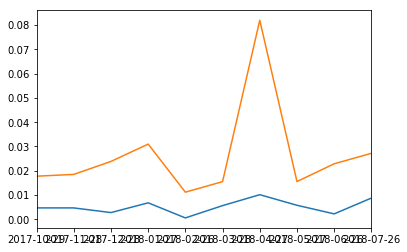

In [79]:
stock_ts['return'].plot()
stock_ts['risk'].plot()

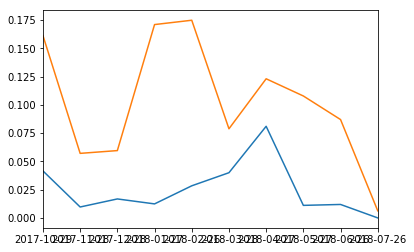

In [80]:
ccur_ts['return'].plot()
ccur_ts['risk'].plot()

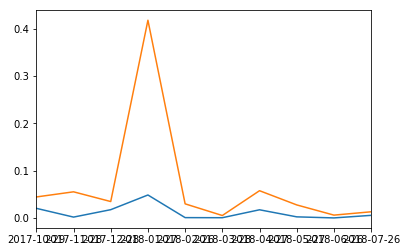

In [81]:
mixed_ts['return'].plot()
mixed_ts['risk'].plot()

In [619]:
# Calcular el VaR como medida interesante y mas fiable de los retornos
# Graficar el plot de las combinaciones de todos las combinaciones de las carteras

## Further outcome analysis

*** Temporal Aggregated Error and residual analysis ***

As the optimization takes place in specific days, the standard error of the estimate is defined as [David Longsteet]:

$$ Standard \ Error = \sqrt{\frac{\sum{{(\hat{Re} - Re)}^2}}{n-2}} $$




In [82]:
def get_errors(simulation_outcomes, returns_df, time_window = 30):
    substract_acum = 0
    predicted_returns, real_returns = list(), list()
    for date_index in simulation_outcomes.index:
        day = datetime.strptime(date_index, '%Y-%m-%d')
        # If the days checked are weekends, the friday before is considered instead
        test_date_index = date_index
        if day.weekday() == 5:
            test_date_index = (day + relativedelta(days = -1)).strftime('%Y-%m-%d')
        elif day.weekday() == 6:
            test_date_index = (day + relativedelta(days = -2)).strftime('%Y-%m-%d')

        # Holiday
        try:
            returns_df.loc[test_date_index]
        except:
            test_date_index = (datetime.strptime(test_date_index, '%Y-%m-%d') + relativedelta(days = -1)).strftime('%Y-%m-%d')
            
        real_return = returns_df.loc[test_date_index].dot(simulation_outcomes.loc[date_index]['weights'])
        predicted_return = simulation_outcomes.loc[date_index]['return']
        
        predicted_returns.append(predicted_return)
        real_returns.append(real_return)
        substract_acum += (np.subtract(predicted_return, real_return))**2
    
    std_error = np.sqrt(np.divide(substract_acum, time_window - 2))
    predicted_returns = pd.Series(predicted_returns)
    predicted_returns.index = simulation_outcomes.index
    real_returns = pd.Series(real_returns)
    real_returns.index = simulation_outcomes.index
    return std_error, predicted_returns, real_returns


In [83]:
# Mixed
mix_std_error, mix_predicted_returns, mix_real_returns = get_errors(mixed_ts, percent_returns_pd, pre_fixed_time_window)
mix_predicted_returns.plot()
mix_real_returns.plot()

KeyError: 'the label [2017-12-27] is not in the [index]'

In [622]:
# stocks
stock_std_error, stock_predicted_returns, stock_real_returns = get_errors(stock_ts, percent_stocks_returns, pre_fixed_time_window)
stock_predicted_returns.plot()
stock_real_returns.plot()

KeyError: 'the label [2017-09-21] is not in the [index]'

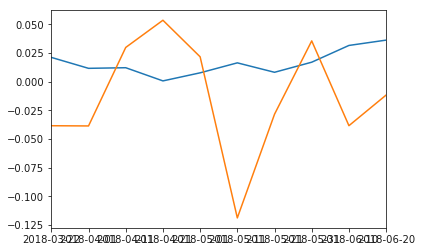

In [574]:
# Crypto
crypto_std_error, ccurr_predicted_returns, ccurr_real_returns = get_errors(ccur_ts, percent_cripto_returns, pre_fixed_time_window)
ccurr_predicted_returns.plot()
ccurr_real_returns.plot()

*** Summarized return in time: real vs predicted ***

Using the outcomes of the simulations, it is possible to measure the aggregated profit  

In [607]:
def get_aggregated_profit_in_percent(returns):  
    ammount = 100
    for rate in returns.values:
        ammount += np.multiply(ammount, rate)
    return np.subtract(ammount, 100)

In [611]:
# stocks comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(stock_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(stock_real_returns)
print('Real aggregated profit using only stocks: ',aggregated_profit_r_return, "%")
print('Predicted aggregated profit using only stocks: ',aggregated_profit_p_return, '%')

Real aggregated profit using only stocks:  -5.3169432463 %
Predicted aggregated profit using only stocks:  4.36274194203 %


In [612]:
# Crypto comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(ccurr_predicted_returns)
aggregated_monetary_r_return = get_aggregated_profit_in_percent(ccurr_real_returns)
print('Real aggregated profit (in percent) using only crypto: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using only crypto: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using only crypto:  -5.3169432463 %
Predicted aggregated profit (in percent) using only crypto:  17.5138898868 %


In [613]:
# stocks comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(mix_predicted_returns)
aggregated_monetary_r_return = get_aggregated_profit_in_percent(mix_real_returns)
print('Real aggregated profit (in percent) using mixed assets: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using mixed asset: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using mixed assets:  -5.3169432463 %
Predicted aggregated profit (in percent) using mixed asset:  6.64458124942 %


*** Mixed assets portfolio distribution of the outcome ***

Once the optimal portoflio has been calculated in each time period where the model ran, it is also desired to explore further whether the composition of mixed protfolios presents any pattern or not. This aims towards giving a basic insight about the optimal distribution of a portfolio of such type by knowing the percent of the capital destinated to stocks and to the criptocurrencies.   

In [546]:
num_stock_asset = len(percent_stocks_returns.columns)
num_cripto_assets = len(percent_cripto_returns.columns)

mixed_ts['percent_in_stocks'] = [100*sum(portfolio[0:num_stock_asset]) for portfolio in mixed_ts['weights']]
mixed_ts['percent_in_cripto'] = [100*sum(portfolio[num_stock_asset:num_stock_asset+num_cripto_assets]) for portfolio in mixed_ts['weights']]

mixed_ts['lag_in_days'] = mixed_ts.index

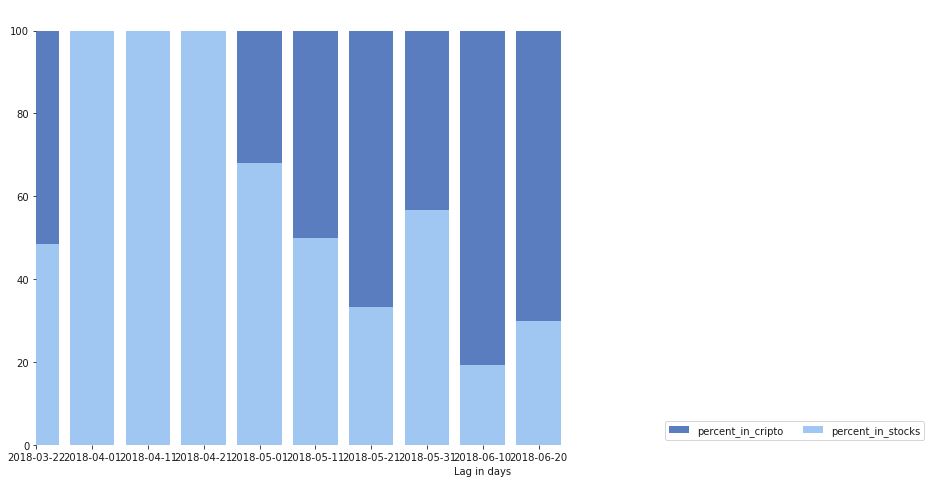

In [547]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Lag in days")
sns.despine(left=True, bottom=True)

In [634]:
# Cleaning df
mixed_ts.drop(['temp_dim', 'lag_in_days'], axis = 1)

,return,risk,weights,portafolio_type,ratio_of_sharpe,percent_in_stocks,percent_in_cripto
150,0.012855,0.045616,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032...",mixed_assets,-0.249399,3.230175,96.769825
120,0.049416,0.095202,"[0.0, 0.0, 0.109338355367, 0.0, 0.0, 0.1488134...",mixed_assets,-0.379809,28.252366,71.747634
90,0.004382,0.035520,"[0.135076513561, 0.135076513561, 0.0, 0.0, 0.0...",mixed_assets,-0.884798,72.984697,27.015303
60,0.004722,0.028266,"[0.335763435359, 0.0, 0.0, 0.280078517722, 0.0...",mixed_assets,-0.738469,61.584195,38.415805
30,0.012323,0.046801,"[0.204504213743, 0.0, 0.0, 0.0, 0.202093331283...",mixed_assets,-0.409423,40.659755,59.340245


# TO DO:

* Clean data, at least for criptocurrencies with few tracking history registers. [X]
* Fix when a big amount of past data is considered when performing optmizations [OK]
* Select most valuable assets of Bovespa [OK - But considering the state in Marxh Only]
* Demonstrate variation between cotations in real and dolar - Not relevant because a differianted series is taken.
* Calculate the mixed portfolios distribution in 3 stages:
    * Ratio of sharpe
    * Max. return
    * Min. Risk
    
* Real error analysis (Mean - retorno real) for normal AVG - and AVG
* GARCH models, calculate the return of a single asset, this will minimize the error.
* Calculate the real return after calculating all optimized portfolios within the defined time interval.